In [1]:
#============================================================================
# calc_cloud_properties.ipynb
#
# Calculates cloud properties from merged ceilometer, radar,
# and sounding datasets and saves to dictionary.
# 
# Program calls on the function 'calc_cloud_properties'
# with the follow required arguments:
# --- infile: Pickle (.pkl) file for a given date containing
#             the merged instrumentation data.
# --- date: date as datetime object
# --- dmin: Distance below cloud base used for precip. detection
# --- ze_thresh: Minimum reflectivity threshold used to emulate
#                instrumentation with other specs.
#
# Author: McKenna W. Stanford
#
#============================================================================

In [2]:
#==================================================
# Imports
#==================================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
#from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
#import pandas as pd
import time
import os
from dask.distributed import Client, progress, LocalCluster
import dask
from scipy import ndimage
#from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from importlib import reload
#from calc_cloud_properties_function import calc_cloud_properties
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import ctypes


In [3]:
#==================================================
# Utility functions
#==================================================
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

def toDatetime(d):
    return datetime.datetime.utcfromtimestamp(d)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx   
def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

In [4]:
#==================================================
# Parameters used in the function
# 'calc_cloud_properties'
#==================================================
dmin_arr = np.arange(50,650,50)
dmin_arr = np.insert(dmin_arr,0,25)
ze_thresh_arr = np.array([-36,-30,-25,-20,-15,-10,-5,0,5,10,15])

In [5]:
#==================================================
# Grab files
#==================================================
path = '/mnt/raid/mwstanfo/micre/merged_instrument_files/'
files = glob.glob(path+'*_arm.p')
files = sorted(files)

dates_dt = []
for ii in range(len(files)):
    fname = files[ii]
    tmp_str = fname.split('/')
    tmp_str = tmp_str[-1]
    tmp_str = tmp_str.split('.')
    tmp_str = tmp_str[0]
    tmp_str = tmp_str.split('_')
    tmp_str = tmp_str[-2]
    tmp_year = int(tmp_str[0:4])
    tmp_month = int(tmp_str[4:6])
    tmp_day = int(tmp_str[6:8])
    dates_dt.append(datetime.datetime(tmp_year,tmp_month,tmp_day,0,0,0))
dates_dt = np.array(dates_dt)

sort_id = np.argsort(dates_dt)
dates_dt = dates_dt[sort_id]
files = np.array(files)[sort_id]

# Processes near-surface profiless (CBH < 250 m AGL)

In [7]:
def step_1(sfc_ref,sfc_ze,sfc_vel,sfc_basta_flag,sfc_Z_min,ze_thresh,in_temp):
    
    num_valid_ids = np.size(np.where(~np.isnan(sfc_ref)))
    
    # determine if radar data is actually present here
    dumid = np.where(sfc_ref > -999.)
    if np.size(dumid) == 0.:
        sfc_ref_mean = -999.
        sfc_ref_grad = -999.
        sfc_vel_min = -999.
        sfc_precip_binary = 0
        sfc_cloud_binary = 0.
        sfc_precip_updraft_binary = -999.
        sfc_IWflx = -999.
        sfc_LWflx = -999.
        sfc_rcb = -999.
        sfc_ref_through_100m_binary = -999.
    elif np.size(dumid) > 0.:
        dumid = np.squeeze(dumid)
        sfc_cloud_binary = 1.
    
        dum_sfc_ze_mean = np.nansum(sfc_ze)/num_valid_ids
        sfc_ref_mean = 10.*np.log10(dum_sfc_ze_mean)
        sfc_vel_min = np.nanmin(sfc_vel)

        if np.nanmin(sfc_vel) > 0.:
            sfc_precip_updraft_binary = 1.
        else:
            sfc_precip_updraft_binary = 0.

        if (sfc_ref[0] > -999.) & (sfc_ref[-1] > -999.):
            sfc_ref_through_100m_binary = 1.
            sfc_ref_grad = (sfc_ref[-1]-sfc_ref[0])/100.
        else:
            sfc_ref_through_100m_binary = 0.
            sfc_ref_grad = -999.

        sfc_Z_min_mean = np.nanmean(sfc_Z_min)
        if sfc_ref_mean > sfc_Z_min_mean:
       # if sfc_ref_mean > ze_thresh:
            sfc_precip_binary = 1.
        else:
            sfc_precip_binary = 0.
        
        if sfc_precip_binary == 1.:
            if ~np.isnan(in_temp):
                if in_temp >= 0.:
                    sfc_LWflx = ((10.**(sfc_ref_mean/10))/25.)**(1/1.3)
                    sfc_IWflx = -999.
                    sfc_rcb = sfc_LWflx
                elif in_temp < 0.:
                    dum_log10IWC = (5.8e-4*sfc_ref_mean* in_temp) + (9.23e-2*sfc_ref_mean) - (7.06e-3*in_temp) - 0.992 # IWC based on Hogan et al., 2006, for 94 GHz.
                    dum_IWC = 10.**(dum_log10IWC)
                    dum_IWflx = dum_IWC*sfc_vel_min*(-3.6)
                    sfc_IWflx = dum_IWflx
                    sfc_LWflx = -999.
                    sfc_rcb = sfc_IWflx                    
            else:
                sfc_LWflx = ((10.**(sfc_ref_mean/10))/25.)**(1/1.3)
                sfc_IWflx = sfc_LWflx
                sfc_rcb = sfc_Lwflx
            
        else:
            sfc_LWflx = -999.
            sfc_IWflx = -999.
            sfc_rcb = -999.
        
    dum_out_dict = {'sfc_precip_binary':sfc_precip_binary,\
                'sfc_cloud_binary':sfc_cloud_binary,\
                'sfc_precip_updraft_binary':sfc_precip_updraft_binary,\
                'sfc_IWflx':sfc_IWflx,\
                'sfc_LWflx':sfc_LWflx,\
                'sfc_rcb':sfc_LWflx,\
                'sfc_ref_mean':sfc_ref_mean,\
                'sfc_vel_min':sfc_vel_min,\
                'sfc_ref_grad':sfc_ref_grad,\
                'sfc_ref_through_100m_binary':sfc_ref_through_100m_binary,\
               }
    return dum_out_dict              

# Identifies fog profiles for ARM ceilometer

In [8]:
def arm_fog_func(arm_ceil_in_dict,basta_time_dt):
    
    backscatter = arm_ceil_in_dict['backscatter']
    native_backscatter = arm_ceil_in_dict['native_backscatter']
    native_time_dt = arm_ceil_in_dict['native_time_dt']
    native_range = arm_ceil_in_dict['native_range']
    interp_height = arm_ceil_in_dict['interp_height']
    native_cbh = arm_ceil_in_dict['native_cbh_1']
    interp_cbh = arm_ceil_in_dict['cbh_1']
    interp_detection_status = arm_ceil_in_dict['detection_status']
    native_detection_status = arm_ceil_in_dict['native_detection_status']
    
    #-------------------------------------
    #-------------------------------------
    # Fog ID
    #-------------------------------------
    #-------------------------------------
    # For interpolated data, we want to come down from cloud base
    # and determine whether or not there is a decade decrease in
    # magnitude before reaching the lowest bin.

    fog_mask = np.zeros(np.shape(basta_time_dt))
    fog_cloud_base_beta_att = np.zeros(np.shape(basta_time_dt))
    fog_min_beta_att = np.zeros(np.shape(basta_time_dt))
    
    min_diff_arr_out = np.zeros(np.shape(basta_time_dt))
    for tt in range(len(basta_time_dt)):
        if (interp_cbh[tt] > 0.) and (interp_cbh[tt] <= 250.):
            height_id = np.where(interp_height == interp_cbh[tt])[0][0]
            cbh_beta = backscatter[height_id,tt]
            fog_cloud_base_beta_att[tt] = cbh_beta
            below_cbh_beta = backscatter[:height_id,tt]
            min_below_cbh_beta = np.nanmin(below_cbh_beta)
            fog_min_beta_att[tt] = min_below_cbh_beta
            dumdiff = cbh_beta - min_below_cbh_beta
            min_diff_arr_out[tt] = dumdiff
            if cbh_beta < -4.5:
                continue
            if np.isnan(dumdiff):
                continue
            elif (~np.isnan(dumdiff)) & (dumdiff >= 1.):
                continue
            elif (~np.isnan(dumdiff)) & (dumdiff < 1.):
                fog_mask[tt] = 1
        else:
            min_diff_arr_out[tt] = np.nan      
    
    
    #dummy = plot_arm_backscatter(native_backscatter,native_time_dt,native_range,native_cbh,native_detection_status,backscatter,basta_time_dt,interp_height,interp_cbh,interp_detection_status,fog_mask)
    
    return fog_mask,fog_cloud_base_beta_att,fog_min_beta_att
  

# Plots ARM ceilometer backscatter on native and interpolated grids

In [9]:
def plot_arm_backscatter(native_backscatter,native_time,native_height,native_cbh,native_detection_status,interp_backscatter,interp_time,interp_height,interp_cbh,interp_detection_status,fog_mask):
    
    start_time = datetime.datetime(interp_time[0].year,interp_time[0].month,interp_time[0].day,0,0)
    end_time = start_time + datetime.timedelta(hours=24)         
    
    fig = plt.figure(figsize=(24,14))
    Fontsize=14
    dfmt = mdates.DateFormatter('%H:%M')
    ax_native = fig.add_subplot(211)
    ax_interp_nn = fig.add_subplot(212)
    
    axlist = [ax_native,ax_interp_nn]
    for ax in axlist:
        ax.tick_params(labelsize=Fontsize)
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.grid(which='both',c='dimgrey',ls='dotted',lw=1)
        ax.set_xlim(start_time,end_time)
        ax.set_ylim(0,2)

    cmap = matplotlib.cm.get_cmap("jet").copy()
    cmap.set_under('navy')
    cmap.set_bad('grey')
    
    #---------------------
    # Native
    #---------------------

    height_bins = native_height-15
    dumbin = np.array([height_bins[-1]+30])
    height_bins = np.concatenate((height_bins,dumbin))

    native_plot = ax_native.pcolormesh(native_time,height_bins*1.e-3,\
                                                     native_backscatter[1:,:].T,\
                                                     cmap=cmap,
                                                     vmin=-8,vmax=-3)
    # Colorbar
    dum_ticks = [-8,-7,-6,-5,-4,-3]
    native_cbar = fig.colorbar(native_plot,ticks=dum_ticks,pad=0.01,ax=ax_native)
    dumstr = '$log_{10}$($\\beta_{att}$)'
    native_cbar.ax.set_ylabel(dumstr,fontsize=Fontsize)
    native_cbar.ax.tick_params(labelsize=Fontsize)  

    ax_native.set_title('Native $\\beta_{att}$ \n 30-m x 16-sec resolution',fontsize=Fontsize*1.5,color='dimgrey')
    ax_native.scatter(native_time,native_cbh*1.e-3,s=2,c='black')
    
    
    # Fill in obscured time periods with transparent red
    id4 = np.where(native_detection_status == 4.)
    detection_mask = np.zeros(np.shape(native_detection_status))
    if np.size(id4) > 1.:
        id4 = np.squeeze(id4)
        detection_mask[id4] = 1
        detection_Objects,num_detection_objects = ndimage.label(detection_mask)
        for kk in range(num_detection_objects):
            dumid = np.where(detection_Objects == kk+1)[0]
            first_id = dumid[0]
            last_id = dumid[-1]
            ax_native.axvspan(native_time[first_id],\
                        native_time[last_id],color='red',alpha=0.5)  
            
            
    #---------------------
    # Interp
    #---------------------    
    basta_height_bins = np.arange(0,np.max(interp_height),25)
    dumbins = np.array([np.max(interp_height)+12.5])
    basta_height_bins = np.concatenate((basta_height_bins,dumbins))
    interp_nn_plot = ax_interp_nn.pcolormesh(interp_time,\
                                                     basta_height_bins*1.e-3,\
                                                     interp_backscatter[:,1:],\
                                                     cmap=cmap,
                                                     vmin=-8,vmax=-3)      


    # Colorbar
    dum_ticks = [-8,-7,-6,-5,-4,-3]
    interp_nn_cbar = fig.colorbar(interp_nn_plot,ticks=dum_ticks,pad=0.01,ax=ax_interp_nn)
    dumstr = '$log_{10}$($\\beta_{att}$)'
    interp_nn_cbar.ax.set_ylabel(dumstr,fontsize=Fontsize)
    interp_nn_cbar.ax.tick_params(labelsize=Fontsize)  

    ax_interp_nn.set_title('Nearest Neighbor Interpolation $\\beta_{att}$ \n 25-m x 12-sec resolution',fontsize=Fontsize*1.5,color='dimgrey')            
    # Interpolated CBH
    ax_interp_nn.scatter(interp_time,interp_cbh*1.e-3,s=2,c='black')


    # Fill in obscured time periods with transparent red
    id4 = np.where(interp_detection_status == 4.)
    detection_mask = np.zeros(np.shape(interp_detection_status))
    if np.size(id4) > 1.:
        id4 = np.squeeze(id4)
        detection_mask[id4] = 1
        detection_Objects,num_detection_objects = ndimage.label(detection_mask)
        for kk in range(num_detection_objects):
            dumid = np.where(detection_Objects == kk+1)[0]
            first_id = dumid[0]
            last_id = dumid[-1]
            ax_interp_nn.axvspan(interp_time[first_id],\
                        interp_time[last_id],color='red',alpha=0.5)               

    red_patch = mpatches.Patch(color='red',alpha=0.5,label='CEIL obscured')
    lgnd = ax_interp_nn.legend(handles=[red_patch],\
                        fontsize=Fontsize*1.5,\
                        bbox_to_anchor=(1,1.2),\
                        ncol=1,loc='upper right',framealpha=0)    

            
    # Shade fog periods
    # Fill in fog time periods with transparent blue
    fog_id = np.where(fog_mask == 1.)
    if np.size(fog_id) > 1.:
        fog_Objects,num_fog_objects = ndimage.label(fog_mask)
        for kk in range(num_fog_objects):
            dumid = np.where(fog_Objects == kk+1)[0]
            first_id = dumid[0]
            last_id = dumid[-1]
            ax_interp_nn.axvspan(interp_time[first_id],\
                        interp_time[last_id],color='navy',alpha=0.5)               

    ax_interp_nn.add_artist(lgnd)
    blue_patch = mpatches.Patch(color='navy',alpha=0.5,label='Fog')
    lgnd2 = ax_interp_nn.legend(handles=[blue_patch],\
                        fontsize=Fontsize*1.5,\
                        bbox_to_anchor=(0,1.2),\
                        ncol=1,loc='upper left',framealpha=0)
            
    plt.subplots_adjust(hspace=0.3,wspace=0.1)
    
    tmp_year = interp_time[0].year
    tmp_month = interp_time[0].month
    tmp_day = interp_time[0].day
    
    date = datetime.datetime(tmp_year,tmp_month,tmp_day,0,0,0)
    dumtime = date.strftime('%Y%m%d')
    fig_path = '/home/mwstanfo/figures/micre_v2/fog_detection/'
    outfile = 'arm_ceil_beta_att_fog_detection_0-2km_{}.png'.format(dumtime)
    plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')       
    plt.close()    
    

# Identifies fog profiles for University of Canterbury ceilometer

In [10]:
def aad_fog_func(aad_ceil_in_dict,basta_time_dt):
    
    backscatter = aad_ceil_in_dict['backscatter']
    native_backscatter = aad_ceil_in_dict['native_backscatter']
    native_time_dt = aad_ceil_in_dict['native_time_dt']
    native_range = aad_ceil_in_dict['native_range']
    interp_height = aad_ceil_in_dict['interp_height']
    native_cbh = aad_ceil_in_dict['native_cbh_1']
    interp_cbh = aad_ceil_in_dict['cbh_1']
    interp_detection_status = aad_ceil_in_dict['detection_status']
    native_detection_status = aad_ceil_in_dict['native_detection_status']

    #-------------------------------------
    #-------------------------------------
    # Fog ID
    #-------------------------------------
    #-------------------------------------
    # For interpolated data, we want to come down from cloud base
    # and determine whether or not there is a decade decrease in
    # magnitude before reaching the lowest bin.

    fog_mask = np.zeros(np.shape(basta_time_dt))
    fog_cloud_base_beta_att = np.zeros(np.shape(basta_time_dt))
    fog_min_beta_att = np.zeros(np.shape(basta_time_dt))
    
    min_diff_arr_out = np.zeros(np.shape(basta_time_dt))
    for tt in range(len(basta_time_dt)):
        if (interp_cbh[tt] > 0.) and (interp_cbh[tt] <= 250.):
            height_id = np.where(interp_height == interp_cbh[tt])[0][0]
            cbh_beta = backscatter[height_id,tt]
            fog_cloud_base_beta_att[tt] = cbh_beta
            below_cbh_beta = backscatter[:height_id,tt]
            min_below_cbh_beta = np.nanmin(below_cbh_beta)
            fog_min_beta_att[tt] = min_below_cbh_beta
            dumdiff = cbh_beta - min_below_cbh_beta
            min_diff_arr_out[tt] = dumdiff
            if cbh_beta < -4.5:
                continue
            if np.isnan(dumdiff):
                continue
            elif (~np.isnan(dumdiff)) & (dumdiff >= 1.):
                continue
            elif (~np.isnan(dumdiff)) & (dumdiff < 1.):
                fog_mask[tt] = 1
        else:
            min_diff_arr_out[tt] = np.nan      
    
    
    #dummy = plot_aad_backscatter(native_backscatter,native_time_dt,native_range,native_cbh,native_detection_status,backscatter,basta_time_dt,interp_height,interp_cbh,interp_detection_status,fog_mask)

    return fog_mask,fog_cloud_base_beta_att,fog_min_beta_att

# Plots University of Canterbury ceilometer backscatter on native and interpolated grids

In [11]:
def plot_aad_backscatter(native_backscatter,native_time,native_height,native_cbh,native_detection_status,interp_backscatter,interp_time,interp_height,interp_cbh,interp_detection_status,fog_mask):
    
    start_time = datetime.datetime(interp_time[0].year,interp_time[0].month,interp_time[0].day,0,0)
    end_time = start_time + datetime.timedelta(hours=24)         
    
    fig = plt.figure(figsize=(24,14))
    Fontsize=14
    dfmt = mdates.DateFormatter('%H:%M')
    ax_native = fig.add_subplot(211)
    ax_interp_nn = fig.add_subplot(212)
    
    axlist = [ax_native,ax_interp_nn]
    for ax in axlist:
        ax.tick_params(labelsize=Fontsize)
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.grid(which='both',c='dimgrey',ls='dotted',lw=1)
        ax.set_xlim(start_time,end_time)
        ax.set_ylim(0,2)

    cmap = matplotlib.cm.get_cmap("jet").copy()
    cmap.set_under('navy')
    cmap.set_bad('grey')
    
    #---------------------
    # Native
    #---------------------

    height_bins = native_height-15
    dumbin = np.array([height_bins[-1]+30])
    height_bins = np.concatenate((height_bins,dumbin))

    native_plot = ax_native.pcolormesh(native_time,height_bins*1.e-3,\
                                                     native_backscatter[1:,:].T,\
                                                     cmap=cmap,
                                                     vmin=-8,vmax=-3)
    # Colorbar
    dum_ticks = [-8,-7,-6,-5,-4,-3]
    native_cbar = fig.colorbar(native_plot,ticks=dum_ticks,pad=0.01,ax=ax_native)
    dumstr = '$log_{10}$($\\beta_{att}$)'
    native_cbar.ax.set_ylabel(dumstr,fontsize=Fontsize)
    native_cbar.ax.tick_params(labelsize=Fontsize)  

    ax_native.set_title('Native $\\beta_{att}$ \n 10-m x 6-sec resolution',fontsize=Fontsize*1.5,color='dimgrey')
    ax_native.scatter(native_time,native_cbh*1.e-3,s=2,c='black')
    
    
    # Fill in obscured time periods with transparent red
    id4 = np.where(native_detection_status == 4.)
    detection_mask = np.zeros(np.shape(native_detection_status))
    if np.size(id4) > 1.:
        id4 = np.squeeze(id4)
        detection_mask[id4] = 1
        detection_Objects,num_detection_objects = ndimage.label(detection_mask)
        for kk in range(num_detection_objects):
            dumid = np.where(detection_Objects == kk+1)[0]
            first_id = dumid[0]
            last_id = dumid[-1]
            ax_native.axvspan(native_time[first_id],\
                        native_time[last_id],color='red',alpha=0.5)  
            
            
    #---------------------
    # Interp
    #---------------------    
    basta_height_bins = np.arange(0,np.max(interp_height),25)
    dumbins = np.array([np.max(interp_height)+12.5])
    basta_height_bins = np.concatenate((basta_height_bins,dumbins))
    interp_nn_plot = ax_interp_nn.pcolormesh(interp_time,\
                                                     basta_height_bins*1.e-3,\
                                                     interp_backscatter[:,1:],\
                                                     cmap=cmap,
                                                     vmin=-8,vmax=-3)      


    # Colorbar
    dum_ticks = [-8,-7,-6,-5,-4,-3]
    interp_nn_cbar = fig.colorbar(interp_nn_plot,ticks=dum_ticks,pad=0.01,ax=ax_interp_nn)
    dumstr = '$log_{10}$($\\beta_{att}$)'
    interp_nn_cbar.ax.set_ylabel(dumstr,fontsize=Fontsize)
    interp_nn_cbar.ax.tick_params(labelsize=Fontsize)  

    ax_interp_nn.set_title('Nearest Neighbor Interpolation $\\beta_{att}$ \n 25-m x 12-sec resolution',fontsize=Fontsize*1.5,color='dimgrey')            
    # Interpolated CBH
    ax_interp_nn.scatter(interp_time,interp_cbh*1.e-3,s=2,c='black')


    # Fill in obscured time periods with transparent red
    id4 = np.where(interp_detection_status == 4.)
    detection_mask = np.zeros(np.shape(interp_detection_status))
    if np.size(id4) > 1.:
        id4 = np.squeeze(id4)
        detection_mask[id4] = 1
        detection_Objects,num_detection_objects = ndimage.label(detection_mask)
        for kk in range(num_detection_objects):
            dumid = np.where(detection_Objects == kk+1)[0]
            first_id = dumid[0]
            last_id = dumid[-1]
            ax_interp_nn.axvspan(interp_time[first_id],\
                        interp_time[last_id],color='red',alpha=0.5)               

    red_patch = mpatches.Patch(color='red',alpha=0.5,label='CEIL obscured')
    lgnd = ax_interp_nn.legend(handles=[red_patch],\
                        fontsize=Fontsize*1.5,\
                        bbox_to_anchor=(1,1.2),\
                        ncol=1,loc='upper right',framealpha=0)    

            
    # Shade fog periods
    # Fill in fog time periods with transparent blue
    fog_id = np.where(fog_mask == 1.)
    if np.size(fog_id) > 1.:
        fog_Objects,num_fog_objects = ndimage.label(fog_mask)
        for kk in range(num_fog_objects):
            dumid = np.where(fog_Objects == kk+1)[0]
            first_id = dumid[0]
            last_id = dumid[-1]
            ax_interp_nn.axvspan(interp_time[first_id],\
                        interp_time[last_id],color='navy',alpha=0.5)               

    ax_interp_nn.add_artist(lgnd)
    blue_patch = mpatches.Patch(color='navy',alpha=0.5,label='Fog')
    lgnd2 = ax_interp_nn.legend(handles=[blue_patch],\
                        fontsize=Fontsize*1.5,\
                        bbox_to_anchor=(0,1.2),\
                        ncol=1,loc='upper left',framealpha=0)
            
    plt.subplots_adjust(hspace=0.3,wspace=0.1)
    
    tmp_year = interp_time[0].year
    tmp_month = interp_time[0].month
    tmp_day = interp_time[0].day
    
    date = datetime.datetime(tmp_year,tmp_month,tmp_day,0,0,0)
    dumtime = date.strftime('%Y%m%d')
    fig_path = '/home/mwstanfo/figures/micre_v2/fog_detection/'
    outfile = 'aad_ceil_beta_att_fog_detection_0-2km_{}.png'.format(dumtime)
    plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
    #plt.show()
    plt.close()
    

# Main Function

In [12]:
#===================================================
#===================================================
#===================================================
#=== MAIN FUNCTION TO CALCULATE CLOUD PROPERTIES ===
#===================================================
#===================================================
#===================================================
def calc_cloud_properties(infile,date,**kwargs):
    #calc_normalized_props=True,calc_fog_props=True,calc_virga_props=True,arb_dbz_cutoff=False):
    calc_normalized_props = kwargs.get('calc_normalized_props',False)
    calc_virga_props = kwargs.get('calc_virga_props',False)
    #calc_fog_props = kwargs.get('calc_fog_props',False)
    arb_dbz_cutoff = kwargs.get('arb_dbz_cutoff',False)
    
    ze_thresh = -36.
    dmin = 100.
    #-------------------------------------------------------------
    # Load pickle file for specific date containing
    # the merged and gridded instruments. 
    #
    # All 2D variables are on the radar time and height
    # grid, all 1D-time variables are interpolated
    # to the radar time grid, and all 1D-height
    # variables are interpolated to the radar height
    # grid.
    #-------------------------------------------------------------
    print(infile)
    pkl_dict = pickle.load(open(infile,"rb"))
    print('Date:',date)
    #-------------------------------------------------------------
    # Initialize empty dictionary that will hold
    # the cloud properties for the entire date
    #-------------------------------------------------------------    
    props_dict = {}
    

    
    #-------------------------------------------------------------   
    # Get flags and masks necessary for calculations
    #-------------------------------------------------------------
    flag_dict = pkl_dict['dataset_flags']
    sfc_met_flag = flag_dict['sfc_met']
    basta_flag = flag_dict['basta']
    interp_sonde_flag = flag_dict['interp_sonde']
    ceil_flag = flag_dict['merge_ceil']
    optics_flag = flag_dict['optics']
    dis_flag = flag_dict['dis']
    arm_ceil_flag = flag_dict['arm_ceil']
    aad_ceil_flag = flag_dict['aad_ceil']
    native_sonde_flag = flag_dict['native_sonde']
    print('basta_flag:',basta_flag)
    print('sfc_met_flag:',sfc_met_flag)
    print('ceil_flag:',ceil_flag)
    print('optics_flag:',optics_flag)
    print('dis_flag:',dis_flag)
    print('interp_sonde_flag:',interp_sonde_flag)
    print('arm_ceil_flag:',arm_ceil_flag)
    print('aad_ceil_flag:',aad_ceil_flag)
    print('native_sonde_flag:',native_sonde_flag)
    
    if basta_flag:
        basta_dict = pkl_dict['basta']
        #-------------------------------------------------------------
        # BASTA radar variables
        # Note that BASTA has already been QC'd here such
        # that any values lying below the minimum theoratical
        # reflectivity are set to -999. (i.e., hydrometeor free)
        # 
        # Also have a 'bad_radar_data_flag' that indicates
        # if data in *the entire* profile is bad.
        #
        # 'basta_flag' is simply the native QC flag
        #-------------------------------------------------------------
        basta_dict = pkl_dict['basta']
        ref = basta_dict['ref']
        vel = basta_dict['vel']
        time_dt = basta_dict['time_dt']
        bad_radar_data_flag = basta_dict['bad_radar_data_flag']
        height = basta_dict['height']
        basta_flag = basta_dict['flag'] 
        #-------------------------------------------------------------
        # Height needs to be rounded to tenth decimal place due
        # to mismatches in significant digits (e.g., 1012.50006
        # needs to be rounded to 1012.5)
        #-------------------------------------------------------------
        height = np.around(height,2)
    else:
        props_dict = None
        return props_dict

    #-------------------------------------------------------------
    # SFC met flag, get SFC met variables    
    #-------------------------------------------------------------
    if sfc_met_flag:
        sfc_dict = pkl_dict['sfc_met']
        sfc_met_temperature = sfc_dict['temperature']
        sfc_met_rh = sfc_dict['rh']
        sfc_met_pressure = sfc_dict['pressure']
        sfc_met_wind_speed = sfc_dict['wind_speed']
        sfc_met_wind_dir = sfc_dict['wind_dir']
    
    #-------------------------------------------------------------
    # Merged ARM & U. of Canterbury ceilometer CBH
    #-------------------------------------------------------------
    # ***FROM CEIL METADATA***
    # Detection status is used for fog detection:
    # detection_status:flag_0_description = "No significant backscatter" ;
    # detection_status:flag_1_description = "One cloud base detected" ;
    # detection_status:flag_2_description = "Two cloud bases detected" ;
    # detection_status:flag_3_description = "Three cloud bases detected" ;
    # detection_status:flag_4_description = "Full obscuration determined but no cloud base detected" ;
    # detection_status:flag_5_description = "Some obscuration detected but determined to be transparent" ;
    # The detection status is time-interpolated and is the same for both ceilometers, though
    # there are no instancnes of flag_5 in the U. of Canterbury data--likely just due to post-processing.       
    if ceil_flag:
        ceil_dict = pkl_dict['merge_ceil']
        ceil_cbh_1 = ceil_dict['cbh_1']  
        ceil_cbh_2 = ceil_dict['cbh_2']  
        ceil_cbh_3 = ceil_dict['cbh_3']  
        ceil_detection_status = ceil_dict['detection_status']
        ceil_cbh_bin_relative_interp = ceil_dict['cbh_bin_relative_interp']
        ceil_source_ceil = ceil_dict['source_ceil']
        thresh_cbh = 7537.5
        dumid = np.where(ceil_cbh_1 > thresh_cbh)
        if np.size(dumid) > 0.:
            ceil_cbh_1[dumid] = -999.
        dumid = np.where(ceil_cbh_2 > thresh_cbh)
        if np.size(dumid) > 0.:
            ceil_cbh_2[dumid] = -999.
        dumid = np.where(ceil_cbh_3 > thresh_cbh)
        if np.size(dumid) > 0.:
            ceil_cbh_3[dumid] = -999.

    if aad_ceil_flag:
        aad_ceil_dict = pkl_dict['aad_ceil']
        aad_ceil_cbh_1 = aad_ceil_dict['cbh_1']
        aad_ceil_backscatter = aad_ceil_dict['backscatter']
        aad_ceil_interp_height = aad_ceil_dict['interp_height']
        #print(np.nanmax(aad_ceil_backscatter))
        #print(np.nanmin(aad_ceil_backscatter))
        
        #------------------------------------------------------------
        #  Do fog flag function
        #------------------------------------------------------------
        aad_fog_mask,aad_fog_cloud_base_beta_att,aad_fog_min_beta_att = aad_fog_func(aad_ceil_dict,time_dt)                
        
        
    if arm_ceil_flag:
        arm_ceil_dict = pkl_dict['arm_ceil']
        arm_ceil_cbh_1 = arm_ceil_dict['cbh_1']
        arm_ceil_detection_status = arm_ceil_dict['detection_status']
        arm_ceil_backscatter = arm_ceil_dict['backscatter']
        arm_ceil_interp_height = arm_ceil_dict['interp_height']
              
        #print(np.nanmax(arm_ceil_backscatter))
        #print(np.nanmin(arm_ceil_backscatter))
        #print(np.nanmin(arm_ceil_cbh_1))
        #print(np.nanmax(arm_ceil_interp_height))
        #print(aaaa)
        #------------------------------------------------------------
        #  Do fog flag function
        #------------------------------------------------------------
        arm_fog_mask,arm_fog_cloud_base_beta_att,arm_fog_min_beta_att = arm_fog_func(arm_ceil_dict,time_dt)
        
    if ceil_flag:
        # Now do a merged fog mask that uses the source ceilometer for the CBH detection
        fog_mask = np.zeros(np.shape(time_dt))
        fog_cloud_base_beta_att = np.zeros(np.shape(time_dt))
        fog_min_beta_att = np.zeros(np.shape(time_dt))
        
        # AAD ceilometer
        if aad_ceil_flag:
            dum_ceil_id = np.where(ceil_source_ceil == 2)
            if np.size(dum_ceil_id) > 0.:
                fog_mask[dum_ceil_id] = aad_fog_mask[dum_ceil_id]
                fog_cloud_base_beta_att[dum_ceil_id] = aad_fog_cloud_base_beta_att[dum_ceil_id]
                fog_min_beta_att[dum_ceil_id] = aad_fog_min_beta_att[dum_ceil_id]

        if arm_ceil_flag:
            # ARM ceilometer
            dum_ceil_id = np.where(ceil_source_ceil == 1)
            if np.size(dum_ceil_id) > 0.:
                fog_mask[dum_ceil_id] = arm_fog_mask[dum_ceil_id]
                fog_cloud_base_beta_att[dum_ceil_id] = arm_fog_cloud_base_beta_att[dum_ceil_id]
                fog_min_beta_att[dum_ceil_id] = arm_fog_min_beta_att[dum_ceil_id]

        fog_mask[np.isnan(ceil_source_ceil)] = np.nan
        fog_cloud_base_beta_att[np.isnan(ceil_source_ceil)] = np.nan
        fog_min_beta_att[np.isnan(ceil_source_ceil)] = np.nan

        
    #-------------------------------------------------------------
    # Interpolated sounding for temperature
    #-------------------------------------------------------------        
    if interp_sonde_flag:
        sonde_temperature = pkl_dict['interp_sonde']['temperature']-273.15
        sonde_rh = pkl_dict['interp_sonde']['rh']
        seconds_to_nearest_sounding = pkl_dict['interp_sonde']['seconds_to_nearest_sounding'] # in timestamp
        #------------------------------------------------------------- 
        # Synoptic Cluster ID
        # From Truong et al. (2020), JGRA,  https://doi.org/10.1029/2020JD033214
        # Cluster IDs are constructed using soundings, so "interpolated"
        # cluster IDs are taken to be valid within 6 hrs on either
        # side of a sounding. For any data not present within 6 hrs of a
        # sounding, the cluster ID is set to NaN.
        #
        # The cluster IDs, as integers, are as follows:
        #
        # -- 1: W1 (Poleward warm advection far ahead of cold front)
        # -- 2: M1 (High-pressure [large-scale subsidence])
        # -- 3: M2 (Cold front)
        # -- 4: M3 (Postfrontal)
        # -- 5: M4 (Warm front)
        # -- 6: C1 (Cicinity of cyclone center)
        #-------------------------------------------------------------
        cluster_id = pkl_dict['interp_sonde']['nearest_cluster_id']
 

        #-------------------------------------------------------------
        # Native Sonde
        #-------------------------------------------------------------  
        if native_sonde_flag:
            tmp_dict = pkl_dict['native_sonde']
            eis_arr = []
            lts_arr = []
            lcl_arr = []
            sonde_time_dt_arr = []
            for ii in range(3):
                dum = pkl_dict['native_sonde'][str(ii+1)]
                if dum is not None:
                    eis_arr.append(dum['eis'])
                    lts_arr.append(dum['lts'])
                    lcl_arr.append(dum['lcl'])
                    sonde_time_dt_arr.append(dum['time_dt'])
                else:
                    eis_arr.append(-999.)
                    lts_arr.append(-999.)
                    lcl_arr.append(-999.)
                    sonde_time_dt_arr.append(-999.)
            eis_arr = np.array(eis_arr)
            lts_arr = np.array(lts_arr)
            lcl_arr = np.array(lcl_arr)

            
            #sonde_time_dt_arr = np.array(sonde_time_dt_arr)
            sonde_time_ts_arr = []
            for dd in range(len(sonde_time_dt_arr)):
                if sonde_time_dt_arr[dd] != -999.:
                    sonde_time_ts_arr.append(toTimestamp(sonde_time_dt_arr[dd]))
                else:
                    sonde_time_ts_arr.append(-999.)
                
                
            sonde_time_ts_arr = np.array(sonde_time_ts_arr)
            
            dumid = np.where(sonde_time_ts_arr > -999.)
            sonde_time_ts_arr = sonde_time_ts_arr[dumid]
            eis_arr = eis_arr[dumid]
            lts_arr = lts_arr[dumid]
            lcl_arr = lcl_arr[dumid]
            
            eis_new_arr = np.zeros(len(seconds_to_nearest_sounding))
            lts_new_arr = np.zeros(len(seconds_to_nearest_sounding))
            lcl_new_arr = np.zeros(len(seconds_to_nearest_sounding))


            time_ts = np.array([toTimestamp(time_dt[dd]) for dd in range(len(time_dt))])

            eis_arr_new = np.zeros(len(time_dt))
            lts_arr_new = np.zeros(len(time_dt))
            lcl_arr_new = np.zeros(len(time_dt))
            

            for tt in range(len(time_ts)):
                if seconds_to_nearest_sounding[tt] <= (6.*60.*60.):
                    diff_time = np.abs(time_ts[tt] - sonde_time_ts_arr)
                    min_diff_time = np.argmin(diff_time)
                    eis_arr_new[tt] = eis_arr[min_diff_time]
                    lts_arr_new[tt] = lts_arr[min_diff_time]
                    lcl_arr_new[tt] = lcl_arr[min_diff_time]
                else:
                    eis_arr_new[tt] = -999.
                    lts_arr_new[tt] = -999.
                    lcl_arr_new[tt] = -999.

        
        
    #-----------------------------------------------
    # If all times have insufficient sonde data,
    # then skip this date entirely
    #-----------------------------------------------
    #if np.all(sonde_sufficient_mask == 0.):
    #    print('Insufficient sonde data on this date. Skipping this date.')
    #    return

    #-----------------------------------------------
    # Grab 'dmin' (distance blow cloud base used for
    # precip detection) and ze_thresh (minimum
    # reflectivity threshold) and allocate them as
    # initial keys to 'props_dict'
    #-----------------------------------------------
    dmin_str = str(dmin)
    #props_dict[dmin_str] = {}
    print('D_min:',dmin)
    
    ze_thresh_str = str(ze_thresh)  
    print('Z_e thresh:',ze_thresh)
    
    #-----------------------------------------------
    # Allocate props_dict with variables we will be computing
    # The variables are as follows:
    # --- 
    # --- time: 12-second time step as a datetime object
    # -------------------------------------------------
    # --- CLOUD GEOMETRIC & MACROPHYSICAL PROPERTIES
    # -------------------------------------------------
    # --- ctt: cloud top temperature (deg C)
    # --- cbt: cloud base temperature (deg C)
    # --- cth: cloud top height (m)
    # --- cbh: cloud base height (m)
    # --- c_thick: cloud layer thickness/depth (m)
    # -------------------------------------------------
    # --- PRECIPITATION PROPERTIES
    # -------------------------------------------------
    # --- IWflx: ice water flux (mm/hr)
    # --- LWflx: liquid water flux (mm/hr)
    # --- rcb: precipitation rate (IWflx + LWflx) (mm/hr)
    # --- sfc_IWflx: surface ice water flux (mm/hr)
    # --- sfc_LWflx: surface liquid water flux (mm/hr)
    # --- sfc_rcb: surface precipitaion rate (sfc_IWflx + sfc_LWflx) (mm/hr)
    # -------------------------------------------------
    # --- PRECIPITATION LAYER PROPERTIES
    # -------------------------------------------------
    # --- ref_mean_bel: layer-avg. reflectivity below CBH within dmin (dBZ)
    # --- vel_min_bel: layer-min. Dop. velocity below CBH within dmin (m/s)
    # --- T_mean_bel: layer-avg. temperature below CBH within dmin (deg C)
    # --- Z_min_mean_bel: layer-avg. minimum reflectivity below CBH within dmin (dBZ)
    # -------------------------------------------------
    # --- SFC PRECIPITATION LAYER PROPERTIES
    # -------------------------------------------------
    # --- sfc_ref_mean: layer-avg. reflectivity at hmin+dmin (dBZ)
    # --- sfc_vel_min: layer-min. Dop. velocity at hmin+dmin (m/s)
    # --- sfc_T_mean: layer-avg. temperature at hmin+dmin (deg C)
    # --- sfc_Z_min_mean: layer-avg. minimum reflectivity at hmin+dmin (dBZ)
    # -------------------------------------------------
    # --- BINARIES
    # -------------------------------------------------
    # --- cloud_binary: 0=no cloud; 1= cloud
    # --- precip_binary: 0=no precipitating cloud; 1=precipitation cloud
    # --- sfc_precip_binary: 0=no precip at sfc; 1=precip at sfc
    # --- precip_to_sfc_binary: 0=precipitating cloud doesn't reach sfc; 1 = precipitating cloud reaches sfc
    # --- precip_updraft_binary: 0=precip within neg. Dop. velocity; 1=precip within pos. Dop. velocity
    # --- sfc_precip_updraft_binary: 0=sfc precip within neg. Dop velocity; 1=sfc precip within pos. Dop. velocity
    # --- virga_binary: 0=no virga; 1=virga
    # --- fog_binary: 0=no fog; 1 = fog
    # --- fog_possible_binary: 0=no potential fog; 1=potential for fog
    # --- single_layer_binary: 0=only 1 cloud layer; 1 = multiple cloud layers
    # --- ref_at_cbh_binary: 0=no reflectivity at cloud base; 1=valid reflectivity at cloud base 
    # --- ref_within_100m_above_cbh_binary: 0=no valid reflectivity within 100m above CBH; 1=valid reflectivity within 100m above CBH
    # --- ref_within_100m_below_cbh_binary: 0=no valid reflectivity within 100m below CBH; 1=valid reflectivity within 100m below CBH
    # --- ref_above_cbh_binary: 0=no valid reflectivity in profile above CBH; 1=valid reflectivity in profile above CBH
    # --- ref_below_cbh_binary: 0=no valid reflectivity in profile below CBH; 1=valid reflectivity in profile below CBH
    # --- cloud_50m_thick_binary: 0=cloud thickness is less than 50m; 1=cloud thickness is greater than or equal to 50m
    # -------------------------------------------------
    # --- MISCELLANEOUS CLOUD STATISTICS
    # -------------------------------------------------
    # --- num_ref_cloud_layers_in_profile: number of cloud layers in profile determined by reflectivity
    # --- num_ceil_cbh_in_profile: number of cloud layers in profile determined by ceilometer (max 3)
    # --- cluster_id: synoptic cluster classification (integer)
    # --- nearest_ref_above_cbh: for ref_at_cbh_binary=0 and ref_above_cbh_binary=1, distance above CBH to nearest valid reflectivity value (m)
    # --- nearest_ref_below_cbh: for ref_at_cbh_binary=0 and ref_below_cbh_binary=1, distance below CBH to nearest valid reflectivity value (m)
    # -------------------------------------------------
    # --- SFC METEOROLOGY
    # -------------------------------------------------
    # --- sfc_rh: sfc met. relative humidity (%)
    # --- sfc_temperature: sfc met. temperature (deg C)
    # --- sfc_pressure: sfc met. pressure (hPa)
    # --- sfc_wind_speed: sfc met. wind speed (m/s)
    # --- sfc_wind_dir: sfc met. wind direction (deg)
    # -------------------------------------------------
    # --- MISCELLANEOUS CLOUD PROPERTIES
    # -------------------------------------------------   
    # --- virga_base_height: base of lowest valid, continuous reflectivity below cloud base (m)
    # --- native_cbh_1: merged ceilometer first CBH without processing
    # --- native_cbh_2: merged ceilometer second CBH without processing
    # --- native_cbh_3: merged ceilometer third CBH without processing
    # -------------------------------------------------
    # --- CBH-NORMALIZED PROFILE PROPERTIES
    # -------------------------------------------------    
    # --- ref_norm_prof_above: reflectivity profile above and including CBH (dBZ)
    # --- vel_norm_prof_above: Dop. velocity profile above and including CBH (m/s)
    # --- T_norm_prof_above: temperature profile above and including CBH (deg C)
    # --- height_norm_prof_above: height profile above and including CBH (m)
    # --- ref_norm_prof_bel: reflectivity profile below CBH (dBZ)
    # --- vel_norm_prof_bel: Dop. velocity profile below CBH (dBZ)
    # --- T_norm_prof_bel: temperature profile below CBH (deg C)
    # --- height_norm_prof_bel: height profile below CBH (m)
    # --- ref_norm_cbh: reflectivity profile normalized by CBH (dBZ)
    # --- vel_norm_cbh: Dop. velocity profile normalized by CBH (m/s)
    # --- height_norm_cbh: height profile normalized by CBH (m)
    # --- T_norm_cbh: emperature profile normalized by CBH (deg C)
    #-----------------------------------------------
    props_dict = {}


    #-----------------------------------------------
    #-----------------------------------------------
    #-----------------------------------------------
    #---------Calculate cloud properties------------
    #-----------------------------------------------
    #-----------------------------------------------
    #-----------------------------------------------
    
    
    #-------------------------------------------------    
    # Parameters
    #-------------------------------------------------    
    Radar_precip_depth_thresh = dmin # depth for precipitation calculations
    Radar_bin_width = 25. # BASTA vertical bin width
    Radar_precip_depth_bin_thresh = int(Radar_precip_depth_thresh/Radar_bin_width) # array length for depth of precip calculations
    
    thresh_seconds_to_nearest_sounding = (60.*60.*6.) # 6 hours
    
    num_times = len(time_dt) # number of 12-second time steps on date

    min_basta_loc = 6 #  -- lowest height index at which BASTA data is valid (i.e., QC'ing for surface clutter)
    hmin = height[min_basta_loc] # 162.5 m -- lowest height at which BASTA data is valid (i.e., QC'ing for surface clutter) # NOTE!: this is the midbin for the 150-175m bin edges
    min_cbh_thresh = hmin + dmin # lowest height at which precipitation calculations can be performed; requires that at least dmin depth be available below CBH for precip. detection

    ref_res = height[1]-height[0] # resolution of BASTA data (same as Radar_bin_width, 25)
    #min_c_thick = ref_res*2. # minimum cloud thickness
    min_sep_for_cat = 25. # minimum separation between valid reflectivity bins for concatenation of layers
    norm_prof_nz = 500 # number of indices used for normalized profiles, equates to 500 bins above or below CBH
    
    #-------------------------------------------------    
    # Calculate minimum detectable Ze threshold
    # as a function of height, where the input is
    # the minimum Ze at 1 km AGL and Z_min is calculated
    # following irradiance weakening inversely proportional
    # to the square of range. Takes 'ze_thresh' from
    # the function input as input
    #-------------------------------------------------
    Z_min_1km = ze_thresh # dBZ, input
    ref_range = 1000. # m
    Z_min = Z_min_1km + 20.*np.log10(height) - 20.*np.log10(ref_range) # dBZ profile
    Z_min[0] = np.nan
    
    
    #-------------------------------------------------
    # Boolean figure for plotting Z_min as a function
    # of height
    #-------------------------------------------------
    if False:
    #if True:
        fig = plt.figure(figsize=(6,6))
        Fontsize=14
        ax1 = fig.add_subplot(111)
        ax1.plot(Z_min,height*1.e-3,c='blue',lw=2,label='$Z_{e,min}$')
        ax1.set_ylabel('Height [km]',fontsize=Fontsize)
        ax1.set_xlabel('Z$_{e,min}$ [dBZ]',fontsize=Fontsize)
        ax1.tick_params(labelsize=Fontsize)
        tmpstr = 'Z$_{e}$ at 1 km: '+ze_thresh_str+' dBZ'
        ax1.text(0.1,0.9,tmpstr,transform=ax1.transAxes,fontsize=Fontsize*1.5)
        tmpstr = 'D$_{min}$: '+dmin_str+'m'
        ax1.text(0.1,0.8,tmpstr,transform=ax1.transAxes,fontsize=Fontsize*1.5)
        ax1.grid(which='both')
        ax1.axhline(1,c='navy',lw=3,label='1 km')
        ax1.legend(fontsize=Fontsize,loc='center left')
        ax1.set_title('$Z_{e,min}$ vs. Height',fontsize=Fontsize*1.5)
        plt.show()
        plt.close()
    
    

    
    #-------------------------------------------------
    # Initialize arrays that will hold cloud properties
    # and will be passed to the dictionary. These
    # will have the same names as the dictionary
    # keys. All values are initialized to -999.
    # Not all variables need to be initialized if they
    # are just pulled from what is read in from the pickle
    # file and are simply being passed to the cloud properties
    # dictionary (i.e., surface met, native ceilometer CBHs)
    #-------------------------------------------------
    interp_sonde_present_binary = np.zeros(num_times)-999.
    ceil_present_binary = np.zeros(num_times)-999.
    sfc_met_present_binary = np.zeros(num_times)-999.
    optics_present_binary = np.zeros(num_times)-999.
    dis_present_binary = np.zeros(num_times)-999.
    
    # Surface Calculations
    sfc_LWflx = np.zeros(num_times)-999.
    sfc_IWflx = np.zeros(num_times)-999.
    sfc_rcb = np.zeros(num_times)-999.
    sfc_ref_mean = np.zeros(num_times)-999.
    sfc_vel_min = np.zeros(num_times)-999.
    #sfc_Z_min_mean = np.zeros(num_times)-999.
    sfc_precip_binary = np.zeros(num_times)-999.
    sfc_cloud_binary = np.zeros(num_times)-999.
    sfc_ref_grad = np.zeros(num_times)-999.
    sfc_temperature_mean = np.zeros(num_times)-999.
    sfc_rh_mean = np.zeros(num_times)-999.
    sfc_ref_through_100m_binary = np.zeros(num_times)-999.
    sfc_precip_updraft_binary = np.zeros(num_times)-999.
    

    
    #-------------------------------------------------
    #-------------------------------------------------
    #-------------------------------------------------
    # Loop through times and do only surface calcualtions
    # since these don't include the ceilometer.
    #-------------------------------------------------
    #-------------------------------------------------
    #-------------------------------------------------

    for tt in range(num_times):
        # Skip time step if there is insufficient sonde data
        #if sonde_sufficient_mask[tt] == 0.:
        #    continue

        # Skip time step if the radar data in profile is bad
        if bad_radar_data_flag[tt] == 1:
            sfc_ref_mean[tt] = np.nan
            sfc_vel_min[tt] = np.nan
            sfc_ref_grad[tt] = np.nan
            sfc_temperature_mean[tt] = np.nan
            sfc_rh_mean[tt] = np.nan
            sfc_precip_binary[tt] = np.nan
            sfc_cloud_binary[tt] = np.nan
            sfc_precip_updraft_binary[tt] = np.nan
            sfc_IWflx[tt] = np.nan
            sfc_LWflx[tt] = np.nan
            sfc_rcb[tt] = np.nan
            sfc_ref_through_100m_binary[tt] = np.nan
            continue
        
        # if there is no ceilometer data, skip time step
        #if np.isnan(ceil_cbh_1[tt]):
        #    continue
            
        # Limit variables to single times for easier workflow
        single_time_ref_prof = ref[:,tt]
        single_time_vel_prof = vel[:,tt]
        single_time_basta_flag = basta_flag[:,tt]
        if interp_sonde_flag:
            single_time_temperature_prof = sonde_temperature[:,tt]
            single_time_rh_prof = sonde_rh[:,tt]
        if sfc_met_flag > 0.:
            single_time_sfc_rh = sfc_met_rh[tt]
            single_time_sfc_temperature = sfc_met_temperature[tt]
            single_time_sfc_wind_speed = sfc_met_wind_speed[tt]
            single_time_sfc_wind_dir = sfc_met_wind_dir[tt]
            single_time_sfc_pressure = sfc_met_pressure[tt]

        
        # Convert from dBZ to equivalent reflectivity (Ze)
        valid_id = np.where((~np.isnan(single_time_ref_prof) | (single_time_ref_prof > -999.)))
        if np.size(valid_id) > 0.:
            single_time_ze_prof = np.zeros(np.shape(single_time_ref_prof))
            single_time_ze_prof[valid_id] = 10.**(single_time_ref_prof[valid_id]/10.)
        invalid_id = np.where(single_time_ref_prof == -999.)
        if np.size(invalid_id) > 0.:
            single_time_ze_prof[invalid_id] = 0.
        nanid = np.where(np.isnan(single_time_ref_prof))
        if np.size(nanid) > 0.:
            single_time_ze_prof[nanid] = np.nan
            


        #==================================================
        #==================================================
        # STEP 1: If radar data is present, perform surface
        # calculations.
        #==================================================
        #==================================================
        sfc_ref = single_time_ref_prof[min_basta_loc:min_basta_loc+4]
        sfc_ze = single_time_ze_prof[min_basta_loc:min_basta_loc+4]
        sfc_vel = single_time_vel_prof[min_basta_loc:min_basta_loc+4]
        if interp_sonde_flag:
            sfc_temperature_sonde = single_time_temperature_prof[min_basta_loc:min_basta_loc+4]
            sfc_rh_sonde = single_time_rh_prof[min_basta_loc:min_basta_loc+4]
        sfc_basta_flag = single_time_basta_flag[min_basta_loc:min_basta_loc+4]
        sfc_Z_min = Z_min[min_basta_loc:min_basta_loc+4]

        # thermodynamics
        if interp_sonde_flag:
            sfc_temperature_mean[tt] = np.nanmean(sfc_temperature_sonde)
            sfc_rh_mean[tt] = np.nanmean(sfc_rh_sonde)
            in_temp = np.nanmean(sfc_temperature_sonde)
        elif sfc_met_flag:
            sfc_temperature_mean[tt] = single_time_sfc_temperature
            sfc_rh_mean[tt] = single_time_sfc_rh
            in_temp = single_time_sfc_temperature
        else:
            sfc_temperature_mean[tt] = np.nan
            sfc_rh_mean[tt] = np.nan
            in_temp = np.nan

        # If no good radar data
        if np.all(np.isnan(sfc_ref)):
            sfc_ref_mean[tt] = np.nan
            sfc_ref_grad[tt] = np.nan
            sfc_vel_min[tt] = np.nan
            sfc_ref_through_100m[tt] = np.nan
            sfc_precip_binary[tt] = np.nan
            sfc_cloud_binary[tt] = np.nan
            sfc_precip_updraft_binary[tt] = np.nan
            sfc_Z_min_mean[tt] = np.nan
        else:
            dum_out_dict = step_1(sfc_ref,sfc_ze,sfc_vel,sfc_basta_flag,sfc_Z_min,ze_thresh,in_temp)

            sfc_ref_mean[tt] = dum_out_dict['sfc_ref_mean']
            sfc_ref_grad[tt] = dum_out_dict['sfc_ref_grad']
            sfc_vel_min[tt] = dum_out_dict['sfc_vel_min']
            sfc_IWflx[tt] = dum_out_dict['sfc_IWflx']
            sfc_LWflx[tt] = dum_out_dict['sfc_LWflx']
            sfc_rcb[tt] = dum_out_dict['sfc_rcb']
            sfc_precip_binary[tt] = dum_out_dict['sfc_precip_binary']
            sfc_cloud_binary[tt] = dum_out_dict['sfc_cloud_binary']
            sfc_precip_updraft_binary[tt] = dum_out_dict['sfc_precip_updraft_binary']
            sfc_ref_through_100m_binary[tt] = dum_out_dict['sfc_ref_through_100m_binary']
    
    
    #==================================================
    #==================================================
    # Step 2: Loop again through profiles and 
    # calculate cloud and precipitation properties
    #==================================================
    #==================================================
    if ceil_flag:
        # Cloud macrophysics
        ctt = np.zeros(num_times)-999.
        cbt = np.zeros(num_times)-999.
        cth = np.zeros(num_times)-999.
        cbh = np.zeros(num_times)-999.
        cbh_2 = np.zeros(num_times)-999.
        cbh_3 = np.zeros(num_times)-999.
        c_thick = np.zeros(num_times)-999.

        # Precip
        IWflx = np.zeros(num_times)-999.
        LWflx = np.zeros(num_times)-999.
        rcb = np.zeros(num_times)-999.

        # Sub-cloud layer properties
        ref_mean_bel = np.zeros(num_times)-999.
        vel_min_bel = np.zeros(num_times)-999.
        temperature_mean_bel = np.zeros(num_times)-999.
        Z_min_mean_bel = np.zeros(num_times)-999.

        # Binaries
        cloud_binary = np.zeros(num_times)-999.
        precip_binary = np.zeros(num_times)-999.
        precip_to_sfc_binary = np.zeros(num_times)-999.
        precip_updraft_binary = np.zeros(num_times)-999.
        single_layer_binary = np.zeros(num_times)-999.
        cbh_bel_min_binary = np.zeros(num_times)-999.
        ref_at_cbh_binary = np.zeros(num_times)-999.
        ref_within_100m_above_cbh_binary = np.zeros(num_times)-999.
        ref_within_100m_below_cbh_binary = np.zeros(num_times)-999.
        ref_above_cbh_binary = np.zeros(num_times)-999.
        ref_below_cbh_binary = np.zeros(num_times)-999.
        cloud_50m_thick_binary = np.zeros(num_times)-999.
        ref_through_100m_above_binary = np.zeros(num_times)-999.
        ref_through_100m_below_binary = np.zeros(num_times)-999.
        ref_grad_above = np.zeros(num_times)-999.
        ref_grad_below = np.zeros(num_times)-999.

        # Virga
        if calc_virga_props:
            virga_base_height = np.zeros(num_times)-999.
            virga_binary = np.zeros(num_times)-999.

        # Fog
        #if calc_fog_props:
        #    fog_binary = np.zeros(num_times)-999.
        #    fog_possible_binary = np.zeros(num_times)-999.

        # Misc.
        num_ref_cloud_layers_in_profile = np.zeros(num_times)-999.
        num_ceil_cbh_in_profile = np.zeros(num_times)-999.
        nearest_ref_above_cbh = np.zeros(num_times)-999.
        nearest_ref_below_cbh = np.zeros(num_times)-999.

        if calc_normalized_props:
            ref_norm_prof_above = np.zeros((num_times,norm_prof_nz))-999.
            vel_norm_prof_above = np.zeros((num_times,norm_prof_nz))-999.
            T_norm_prof_above = np.zeros((num_times,norm_prof_nz))-999.
            height_norm_prof_above = np.zeros((num_times,norm_prof_nz))-999.
            ref_norm_prof_bel = np.zeros((num_times,norm_prof_nz))-999.
            vel_norm_prof_bel = np.zeros((num_times,norm_prof_nz))-999.
            T_norm_prof_bel = np.zeros((num_times,norm_prof_nz))-999.
            height_norm_prof_bel = np.zeros((num_times,norm_prof_nz))-999.
            T_norm_cbh = np.zeros((num_times,norm_prof_nz))-999.
            ref_norm_cbh = np.zeros((num_times,norm_prof_nz))-999.
            vel_norm_cbh = np.zeros((num_times,norm_prof_nz))-999.
            height_norm_cbh = np.zeros((num_times,norm_prof_nz))-999.

        for tt in range(num_times):

            # Skip time step if radar data is bad or detection status indicates missing CEIL
            if (bad_radar_data_flag[tt] == 1) or (np.isnan(ceil_detection_status[tt])):
                cloud_binary[tt] = np.nan
                continue
    
            single_time_ceil_ds = ceil_detection_status[tt]
            # Skip profile if ceilometer determines the sky is clear or the ceilometer is obscured                
            if (single_time_ceil_ds == 0.) or (single_time_ceil_ds == 5.):
                cloud_binary[tt] = 0
                continue
            
            if (single_time_ceil_ds == 4.):
                cloud_binary[tt] = np.nan
                continue
                
            #if np.isnan(ceil_cbh_1[tt]):
            #    cloud_binary[tt] = np.nan
            #    continue
            
            if np.isnan(single_time_ceil_ds):
                cloud_binary[tt] = np.nan
                continue

            # Limit variables to single times for easier workflow
            single_time_ref_prof = ref[:,tt]
            single_time_vel_prof = vel[:,tt]
            single_time_basta_flag = basta_flag[:,tt]
            single_time_cbh = ceil_cbh_1[tt]
            single_time_ceil_cbh_bin_relative_interp = ceil_cbh_bin_relative_interp[tt]
            
            # Convert from dBZ to equivalent reflectivity (Ze)
            valid_id = np.where((~np.isnan(single_time_ref_prof) | (single_time_ref_prof > -999.)))
            if np.size(valid_id) > 0.:
                single_time_ze_prof = np.zeros(np.shape(single_time_ref_prof))
                single_time_ze_prof[valid_id] = 10.**(single_time_ref_prof[valid_id]/10.)
            invalid_id = np.where(single_time_ref_prof == -999.)
            if np.size(invalid_id) > 0.:
                single_time_ze_prof[invalid_id] = 0.
            nanid = np.where(np.isnan(single_time_ref_prof))
            if np.size(nanid) > 0.:
                single_time_ze_prof[nanid] = np.nan            
            
            
            if interp_sonde_flag:
                single_time_temperature_prof = sonde_temperature[:,tt]
                
            cbh[tt] = single_time_cbh
            
            # Skip time if the CBH is less than the minimum allowable (hmin+dmin)
            if single_time_cbh < min_cbh_thresh:
                cbh_bel_min_binary[tt] = 1
                cloud_binary[tt] = -1.
                continue
            
            # If here, then there is cloud above hmin+dmin
            cloud_binary[tt] = 1
            cbh_bel_min_binary[tt] = 0
            # Find the height ID matching the CBH
            height_id = np.where(height == single_time_cbh)[0][0]
            
            #-------------------------------------------------  
            # Normalize profiles by CBH, both above and below
            #-------------------------------------------------  
            # Above CBH -- includes CBH bin reflectivity value
            ref_above_cbh_prof = single_time_ref_prof[height_id:]
            ze_above_cbh_prof = single_time_ze_prof[height_id:]
            vel_above_cbh_prof = single_time_vel_prof[height_id:]
            if interp_sonde_flag:
                temperature_above_cbh_prof = single_time_temperature_prof[height_id:]
            height_above_cbh_prof = height[height_id:]

            # Below CBH -- last index is one bin below cloud base
            ref_below_cbh_prof = single_time_ref_prof[0:height_id]
            ze_below_cbh_prof = single_time_ze_prof[0:height_id]
            vel_below_cbh_prof = single_time_vel_prof[0:height_id]
            if interp_sonde_flag:
                temperature_below_cbh_prof = single_time_temperature_prof[0:height_id]
            height_below_cbh_prof = height[0:height_id]
            Z_min_below_cbh_prof = Z_min[0:height_id]
            
            # Special case where the CBH reading lies along the edge of a BASTA bin,
            # so we want to check the reflectivity bin above as well and see if there
            # is reflectivity in that bin
            if single_time_ceil_cbh_bin_relative_interp == 1.:
                if (np.isnan(ref_above_cbh_prof[0])) or (np.isnan(ref_above_cbh_prof[1])):
                    ref_at_cbh_binary[tt] = np.nan
                elif ref_above_cbh_prof[0] > -999.:
                    ref_at_cbh_binary[tt] = 1
                elif (ref_above_cbh_prof[0] == -999.) and (ref_above_cbh_prof[1] > -999.):
                    ref_at_cbh_binary[tt] = 1
                elif (ref_above_cbh_prof[0] == -999.) and (ref_above_cbh_prof[1] == -999.):
                    ref_at_cbh_binary[tt] = 0.
                else:
                    print(ref_above_cbh_prof[0:4])
                    print('here')
            else:
                dum_ref = ref_above_cbh_prof[0]
                if dum_ref > -999.:
                    ref_at_cbh_binary[tt] = 1
                else:
                    ref_at_cbh_binary[tt] = 0
                    
            if ref_at_cbh_binary[tt] == -999.:
                print(single_time_ceil_cbh_bin_relative_interp)
                raise RuntimeError('Do Better')


            #----------------------------------
            # Macrophysics
            #----------------------------------
            if ref_at_cbh_binary[tt] == 1.:
            
                # Create cloud mask
                cloud_layer_mask = np.zeros(len(ref_above_cbh_prof))
                # Mark CBH as a "1" in cloud_layer_mask
                cloud_layer_mask[0] = 1
                if single_time_ceil_cbh_bin_relative_interp == 1.:
                    cloud_layer_mask[1] = 1

                # Now identify cloudy grid cells using reflectivity
                valid_ref_id = np.where(ref_above_cbh_prof > -999.)
                if np.size(valid_ref_id) > 0.:
                    cloud_layer_mask[valid_ref_id] = 1

                # Identify contiguous cloudy grid cells
                cloud_Objects,num_cloud_objects = ndimage.label(cloud_layer_mask)

                # If there is more than one cloud object, concatenate cloud layers
                # separated by a minimum of min_sep_for_cat (default = 50 m)
                if num_cloud_objects > 1:
                    alt_diff = np.zeros(num_cloud_objects-1)
                    unique_ids = np.unique(cloud_Objects)
                    unique_ids = unique_ids[1:]

                    for jj in range(len(unique_ids)-1):
                        ids_layer_1 = np.where(cloud_Objects == jj+1)
                        ids_layer_1 = ids_layer_1[0]
                        ids_layer_2 = np.where(cloud_Objects == jj+2)
                        ids_layer_2 = ids_layer_2[0]

                        if np.size(ids_layer_1) == 1:
                            layer_1_top = ids_layer_1[0]
                        else:
                            layer_1_top = ids_layer_1[-1]

                        if np.size(ids_layer_2) == 1:
                            layer_2_bottom = ids_layer_2[0]
                        else:
                            layer_2_bottom = ids_layer_2[0]

                        alt_diff[jj] =  (layer_2_bottom-layer_1_top)*ref_res     


                    # create a new cloud mask that accounts for concatenating layers
                    # separated by less than or equal to 50 m
                    for jj in range(len(alt_diff)):
                        if alt_diff[jj] <= (min_sep_for_cat):
                            ids_layer_1 = np.where(cloud_Objects == jj+1)
                            ids_layer_1 = ids_layer_1[0]
                            ids_layer_2 = np.where(cloud_Objects == jj+2)
                            ids_layer_2 = ids_layer_2[0]
                            cloud_layer_mask[ids_layer_1[0]:ids_layer_2[-1]+1] = 1

                    # Redo object identification
                    cloud_Objects,num_cloud_objects = ndimage.label(cloud_layer_mask)             

                #-------------------------------------------------                               
                # Calculate macrophysical and base/height properties
                #-------------------------------------------------                            

                first_cloud_object_mask_id = np.where(cloud_Objects == 1)[0]
                tmp_c_thick = (len(first_cloud_object_mask_id))*ref_res    
                c_thick[tt] = tmp_c_thick

                if tmp_c_thick >= 50:
                    cloud_50m_thick_binary[tt] = 1
                else:
                    cloud_50m_thick_binary[tt] = 0

                if interp_sonde_flag:
                    cbt[tt] = temperature_above_cbh_prof[first_cloud_object_mask_id[0]]
                    ctt[tt] = temperature_above_cbh_prof[first_cloud_object_mask_id[-1]]
                else:
                    cbt[tt] = np.nan
                    ctt[tt] = np.nan
                cth[tt] = height_above_cbh_prof[first_cloud_object_mask_id[-1]]
                #cbh[tt] = single_time_cbh
            else:
                # ref_at_cbh_binary == 0.

                #------------------------------------------------- 
                # Check to see if there is any valid reflectivity
                # below CBH.
                # This is reported using 'ref_below_cbh_binary'
                # This is done here only to see how often there
                # is an altitude difference between the ceilometer
                # CBH and the first valid reflectivity below
                # cloud base.
                #-------------------------------------------------
                ref_below_id = np.where( (ref_below_cbh_prof > -999.) & (~np.isnan(ref_below_cbh_prof)))[0]
                if np.size(ref_below_id) > 0.:
                    ref_below_cbh_binary[tt] = 1

                    #------------------------------------------------- 
                    # Find the nearest reflectivity below cloud base
                    # and record the altitude difference.
                    #-------------------------------------------------
                    nearest_ref_below_cbh_height = height_below_cbh_prof[ref_below_id[-1]]
                    ref_below_alt_diff = single_time_cbh - nearest_ref_below_cbh_height
                    nearest_ref_below_cbh[tt] = ref_below_alt_diff
                    if ref_below_alt_diff <= 100.:
                        ref_within_100m_below_cbh_binary[tt] = 1
                    else:
                        ref_within_100m_below_cbh_binary[tt] = 0

                else:
                    ref_below_cbh_binary[tt] = 0
                    ref_within_100m_below_cbh_binary[tt] = 0
                
                
                
                #------------------------------------------------- 
                # Find the nearest reflectivity above cloud base
                # and record the altitude difference.
                #-------------------------------------------------
                ref_above_id = np.where((ref_above_cbh_prof > -999.) & (~np.isnan(ref_above_cbh_prof)))[0]
                # ref exists above cbh
                if np.size(ref_above_id) > 0.:
                    ref_above_cbh_binary[tt] = 1
                    nearest_ref_above_cbh_height = height_above_cbh_prof[ref_above_id[0]]
                    ref_above_alt_diff = nearest_ref_above_cbh_height - single_time_cbh
                    nearest_ref_above_cbh[tt] = ref_above_alt_diff  
                    
                    #------------------------------------------------- 
                    # Check to see if the nearest reflectivity value
                    # above cloud base is less than or equal to 100 m
                    # from CBH.
                    #-------------------------------------------------                       

                    if ref_above_alt_diff <= 100.:
                        ref_within_100m_above_cbh_binary[tt] = 1
                    else:
                        ref_within_100m_above_cbh_binary[tt] = 0.
                        

                        
                    # need "num_cloud_objects" now, that's all this following block is for

                    # Create cloud mask
                    cloud_layer_mask = np.zeros(len(ref_above_cbh_prof))
                    # Mark CBH as a "1" in cloud_layer_mask
                    cloud_layer_mask[0] = 1
                    if single_time_ceil_cbh_bin_relative_interp == 1.:
                        cloud_layer_mask[1] = 1

                    # Now identify cloudy grid cells using reflectivity
                    valid_ref_id = np.where(ref_above_cbh_prof > -999.)
                    if np.size(valid_ref_id) > 0.:
                        cloud_layer_mask[valid_ref_id] = 1

                    # Identify contiguous cloudy grid cells
                    cloud_Objects,num_cloud_objects = ndimage.label(cloud_layer_mask)

                    # If there is more than one cloud object, concatenate cloud layers
                    # separated by a minimum of min_sep_for_cat (default = 50 m)
                    if num_cloud_objects > 1:
                        alt_diff = np.zeros(num_cloud_objects-1)
                        unique_ids = np.unique(cloud_Objects)
                        unique_ids = unique_ids[1:]

                        for jj in range(len(unique_ids)-1):
                            ids_layer_1 = np.where(cloud_Objects == jj+1)
                            ids_layer_1 = ids_layer_1[0]
                            ids_layer_2 = np.where(cloud_Objects == jj+2)
                            ids_layer_2 = ids_layer_2[0]

                            if np.size(ids_layer_1) == 1:
                                layer_1_top = ids_layer_1[0]
                            else:
                                layer_1_top = ids_layer_1[-1]

                            if np.size(ids_layer_2) == 1:
                                layer_2_bottom = ids_layer_2[0]
                            else:
                                layer_2_bottom = ids_layer_2[0]

                            alt_diff[jj] =  (layer_2_bottom-layer_1_top)*ref_res     


                        # create a new cloud mask that accounts for concatenating layers
                        # separated by less than or equal to 50 m
                        for jj in range(len(alt_diff)):
                            if alt_diff[jj] <= (min_sep_for_cat):
                                ids_layer_1 = np.where(cloud_Objects == jj+1)
                                ids_layer_1 = ids_layer_1[0]
                                ids_layer_2 = np.where(cloud_Objects == jj+2)
                                ids_layer_2 = ids_layer_2[0]
                                cloud_layer_mask[ids_layer_1[0]:ids_layer_2[-1]+1] = 1

                        # Redo object identification
                        cloud_Objects,num_cloud_objects = ndimage.label(cloud_layer_mask)
                        
                        #-------------------------------------------------                               
                        # Calculate macrophysical and base/height properties
                        #-------------------------------------------------                            

                        first_cloud_object_mask_id = np.where(cloud_Objects == 1)[0]
                        tmp_c_thick = (len(first_cloud_object_mask_id))*ref_res    
                        c_thick[tt] = tmp_c_thick

                        if tmp_c_thick >= 50:
                            cloud_50m_thick_binary[tt] = 1
                        else:
                            cloud_50m_thick_binary[tt] = 0
                        if interp_sonde_flag:
                            cbt[tt] = temperature_above_cbh_prof[first_cloud_object_mask_id[0]]
                            ctt[tt] = temperature_above_cbh_prof[first_cloud_object_mask_id[-1]]
                        cth[tt] = height_above_cbh_prof[first_cloud_object_mask_id[-1]]
                        

                # reflectivity doesn't exist above cbh at all      
                else:
                    ref_above_cbh_binary[tt] = 0
                    ref_within_100m_above_cbh_binary[tt] = 0.
                    num_cloud_objects = 1
                    c_thick[tt] = 0.
                    if interp_sonde_flag:
                        cbt[tt] = temperature_above_cbh_prof[0]
                        ctt[tt] = cbt[tt]
                    cth[tt] = cbh[tt]
                    cloud_50m_thick_binary[tt] = 0.                    
            
            
            ###########################
            num_ref_cloud_layers_in_profile[tt] = num_cloud_objects
            # Assign properties according to number of layers
            if num_cloud_objects > 1:
                single_layer_binary[tt] = 0
            else:
                single_layer_binary[tt] = 1                
                
            #----------------------------------            
            #----------------------------------            
            # Subcloud-layer properties
            #----------------------------------
            #----------------------------------

            ref_100m_above = ref_above_cbh_prof[0:4]
            ze_100m_above = ze_above_cbh_prof[0:4]
            ref_100m_below = ref_below_cbh_prof[-4:]
            ze_100m_below = ze_below_cbh_prof[-4:]
            vel_100m_below = vel_below_cbh_prof[-4:]
            Z_min_100m_below = Z_min_below_cbh_prof[-4:]
        
            
            if interp_sonde_flag:
                temperature_100m_below = temperature_below_cbh_prof[-4:]
                temperature_mean_bel[tt] = np.nanmean(temperature_below_cbh_prof)
            else:
                temperature_mean_bel[tt] = np.nan
                
            
            # If all values are NaN surrounding the CBH
            if np.all(np.isnan(ref_100m_above)) or np.all(np.isnan(ref_100m_below)):
                ref_mean_bel[tt] = np.nan
                vel_min_bel[tt] = np.nan
                ref_grad_above[tt] = np.nan
                ref_grad_below[tt] = np.nan
                rcb[tt] = np.nan
                IWflx[tt] = np.nan
                LWflx[tt] = np.nan
                Z_min_mean_bel[tt] = np.nan
                precip_binary[tt] = np.nan
                precip_to_sfc_binary[tt] = np.nan
                precip_updraft_binary[tt] = np.nan
                continue

            
            # If here, then we have some context about the cloud via reflectivity
            if np.all(ref_100m_above > -999.):
                ref_through_100m_above_binary[tt] = 1
                # calculate gradient
                # positive means reflectivity increases from cloud base
                ref_grad_above[tt] = (ref_100m_above[-1]-ref_100m_above[0])/100.
            else:
                ref_through_100m_above_binary[tt] = 0
                
            if np.all(ref_100m_below > -999.):
                ref_through_100m_below_binary[tt] = 1
                # calculate gradient
                # positive means reflectivity increases toward cloud base
                ref_grad_below[tt] = (ref_100m_below[-1]-ref_100m_below[0])/100.
            else:
                ref_through_100m_below_binary[tt] = 0
                
            # Average reflectivity below cloud base
            # Also pull out the minimum doppler velocity
            dumid = np.where((~np.isnan(ref_100m_below)) & (ref_100m_below > -999.))
            if np.size(dumid) > 0.:
                dumid = np.squeeze(dumid)
                dum_ze_mean = np.nansum(ze_100m_below)/4.
                dum_ref_mean = 10.*np.log10(dum_ze_mean)
                ref_mean_bel[tt] = dum_ref_mean
                
                dum_min_vel = np.nanmin(vel_100m_below)
                if dum_min_vel > 0.:
                    precip_updraft_binary[tt] = 1.
                else:
                    precip_updraft_binary[tt] = 0.
                    
                vel_min_bel[tt] = dum_min_vel
                dum_Z_min_ze_100m_below = 10.**(Z_min_100m_below/10.)
                Z_min_ze_mean_100m_below = np.nansum(dum_Z_min_ze_100m_below)/4.
                Z_min_mean_bel[tt] = 10.*(np.log10(Z_min_ze_mean_100m_below))
                
                #if dum_ref_mean > ze_thresh:
                if dum_ref_mean > Z_min_mean_bel[tt]:
                    precip_binary[tt] = 1
                else:
                    precip_binary[tt] = 0.
            else:
                #ref_mean_bel[tt] = np.nan
                #vel_min_bel[tt] = np.nan
                #Z_min_mean_bel[tt] = np.nan
                precip_binary[tt] = 0
                
            if precip_binary[tt] == 1.:
                # Calculate precip rate
                if interp_sonde_flag:
                    in_temp = temperature_mean_bel[tt]
                    if in_temp >= 0.:
                        IWflx[tt] = -999.
                        LWflx[tt] = ((10.**(ref_mean_bel[tt]/10))/25.)**(1/1.3)
                        rcb[tt] = LWflx[tt]
                    elif in_temp < 0.:
                        dum_log10IWC = (5.8e-4*ref_mean_bel[tt]* in_temp) + (9.23e-2*ref_mean_bel[tt]) - (7.06e-3 * in_temp) - 0.992 # IWC based on Hogan et al., 2006, for 94 GHz.
                        dum_IWC = 10.**(dum_log10IWC)
                        dum_IWflx = dum_IWC*vel_min_bel[tt]*(-3.6)
                        IWflx[tt] = dum_IWflx
                        LWflx[tt] = -999.
                        rcb[tt] = IWflx[tt]                 
                else:
                    IWflx[tt] = np.nan
                    LWflx[tt] = np.nan
                    rcb[tt] = np.nan
                    
            # Virga
            #-------------------------------------------------                    
            # Check to see if precipitation is continuous to the surface.
            #
            # If it is not and the Boolean calc_virga_props == True,
            # then calculate the virga base height.
            #
            # Note that virga is calculated whether or not there
            # is valid reflectivity at cloud base. This is to account
            # for scenarios where a geometrically thin liquid cloud
            # precipitates into a sub-cloud layer that is subsaturated
            # w.r.t. liquid but supersaturated w.r.t ice and the ice
            # grows and then sublimates. Probably a rare occurrence,
            # but we still want to document it.
            #-------------------------------------------------
            if precip_binary[tt] == 1.:
                # First, limit profiles to only those above hmin (162.5 m, midbin of 150-175 m range gates)
                ref_below_cbh_prof_lim = ref_below_cbh_prof[min_basta_loc:]
                height_below_cbh_prof_lim = height_below_cbh_prof[min_basta_loc:]
                Z_min_below_cbh_prof_lim = Z_min_below_cbh_prof[min_basta_loc:]
                # This line is only relevant for Z_min > -36 dBZ at 1 km.
                ref_below_cbh_prof_lim[ref_below_cbh_prof_lim < Z_min_below_cbh_prof_lim] = -999.

                # Check to see if all values below CBH are valid reflectivity values
                if np.all(ref_below_cbh_prof_lim > -999.) & np.all(~np.isnan(ref_below_cbh_prof_lim)):
                    precip_to_sfc_binary[tt] = 1
                    if calc_virga_props:
                        virga_binary[tt] = 0
                else:


                    # Check for NaNs below CBH.
                    nanid = np.where(np.isnan(ref_below_cbh_prof_lim))
                    if np.size(nanid) > 0.:
                        # There are NaNs in the profile below CBH.
                        # Note that NaNs do not mean hydrometeor-free range gates but rather
                        # values that have been QC'd and determined to be "bad". In this case,
                        # we want at least 75% of the data below CBH to NOT NaNs in order
                        # to perform a computation.
                        frac_bad_size = np.size(nanid)/np.size(ref_below_cbh_prof_lim)
                        if frac_bad_size < 0.25:
                            # Less than 25% of the data below cloud base are NaNs

                            # First, grab a reflectivity profile that excludes the NaNs
                            # If every value other than the NaNs are valid (i.e., not -999.)
                            # then we will say the cloud is precipitating to the surface

                            ref_below_cbh_prof_lim_no_nans = ref_below_cbh_prof_lim[~np.isnan(ref_below_cbh_prof_lim)]
                            if np.all(ref_below_cbh_prof_lim_no_nans > -999.):
                                precip_to_sfc_binary[tt] = 1
                                if calc_virga_props:
                                    virga_binary[tt] = 0
                            elif np.all(ref_below_cbh_prof_lim_no_nans == -999.):
                                # Just a sanity check. This shouldn't happen.
                                raise RuntimeError('Something went wrong')
                            else:
                                precip_to_sfc_binary[tt] = 0
                                if calc_virga_props:
                                    virga_binary[tt] = 1
                                    # If here, then there are NaNs (but no more than 25%)
                                    # below cloud base and there are some valid hydrometeor-
                                    # containing range gates (> -999.). In thise case, we'll
                                    # make a cloud mask with NaNs, loop down from cloud base,
                                    # skip over the NaNs, and find the first cloud mask that is
                                    # 0. 
                                    ref_below_cbh_prof_lim_rev = np.flip(ref_below_cbh_prof_lim)
                                    height_below_cbh_prof_lim_rev = np.flip(height_below_cbh_prof_lim)
                                    # Note that these "virga" prefixes associate with reversed arrays
                                    virga_cloud_mask = np.zeros(np.shape(ref_below_cbh_prof_lim_rev))
                                    valid_virga_cloud_id = np.where(ref_below_cbh_prof_lim_rev > -999.)
                                    valid_virga_cloud_id = np.squeeze(valid_virga_cloud_id)
                                    virga_cloud_mask[valid_virga_cloud_id] = 1
                                    virga_nan_id = np.where(np.isnan(ref_below_cbh_prof_lim_rev))
                                    virga_cloud_mask[virga_nan_id] = np.nan

                                    # Limit virga cloud mask to only those values within depth dmin
                                    virga_cloud_mask_dmin = virga_cloud_mask[0:Radar_precip_depth_bin_thresh]
                                    virga_cloud_mask_id_dmin = np.where(virga_cloud_mask_dmin == 1.)
                                    virga_cloud_mask_id_dmin = np.squeeze(virga_cloud_mask_id_dmin)
                                    virga_cloud_mask_id_dmin_max = np.max(virga_cloud_mask_id_dmin) # value where last reflectivity point is valid within dmin depth below cloud base

                                    # Find all values in profile scanning from first valid reflectivity below cloud base *within dmin)
                                    # to the value where the virga_cloud mask == 0 minus 1 (kkk-1)
                                    for kkk in range(virga_cloud_mask_id_dmin_max,len(virga_cloud_mask)):
                                        if np.isnan(virga_cloud_mask[kkk]):
                                            pass
                                        elif virga_cloud_mask[kkk] == 1.:
                                            pass
                                        elif virga_cloud_mask[kkk] == 0.:
                                            # limit virga cloud mask to only those values before reaching a "zero" (non-cloud)
                                            virga_cloud_mask_lim = virga_cloud_mask[0:kkk]
                                            virga_cloud_mask_height_lim = height_below_cbh_prof_lim_rev[0:kkk]
                                            virga_cloud_mask_lim_id = np.where(virga_cloud_mask_lim == 1.)
                                            virga_cloud_mask_lim_id = np.squeeze(virga_cloud_mask_lim_id)
                                            last_valid_height_id = np.max(virga_cloud_mask_lim_id)
                                            last_valid_height = virga_cloud_mask_height_lim[last_valid_height_id]
                                            virga_base_height[tt] = last_valid_height   
                                            break
                        else:
                            # More than 75% of the data below cloud base are NaNs
                            precip_to_sfc_binary[tt] = np.nan # undetermined
                            if calc_virga_props:
                                virga_binary[tt] = np.nan # undetermined                                
                    else:
                        # There are no NaNs in the profile below CBH, however
                        # not all bins have hydrometeors (i.e., some are -999.)
                        # In this case, precip does not reach the surface and we
                        # calculate virga base height

                        precip_to_sfc_binary[tt] = 0

                        if calc_virga_props:
                            virga_binary[tt] = 1

                            # reverse the array
                            ref_below_cbh_prof_lim_rev = np.flip(ref_below_cbh_prof_lim)
                            height_below_cbh_prof_lim_rev = np.flip(height_below_cbh_prof_lim)

                            # There are cases where there is no reflectivity at cloud base
                            # but there is precipitation below cloud base (perhaps
                            # the formation of ice crystals below liquid cloud base?)
                            virga_cloud_mask = np.zeros(np.shape(ref_below_cbh_prof_lim_rev))
                            virga_cloud_mask_id = np.where(ref_below_cbh_prof_lim_rev > -999.)
                            virga_cloud_mask_id = np.squeeze(virga_cloud_mask_id)
                            virga_cloud_mask[virga_cloud_mask_id] = 1

                            # Limit virga cloud mask to only those values within depth dmin
                            virga_cloud_mask_dmin = virga_cloud_mask[0:Radar_precip_depth_bin_thresh]
                            if np.size(virga_cloud_mask_dmin) > 1:
                                virga_cloud_mask_id_dmin = np.where(virga_cloud_mask_dmin == 1.)
                                virga_cloud_mask_id_dmin = np.squeeze(virga_cloud_mask_id_dmin)
                                virga_cloud_mask_id_dmin_max = np.max(virga_cloud_mask_id_dmin) # value where last reflectivity point is valid within dmin depth below cloud base
                            elif np.size(virga_cloud_mask_dmin) == 1.:
                                virga_cloud_mask_id_dmin_max = 0
                            # Find all values in profile scanning from first valid reflectivity below cloud base *within* dmin)
                            # to the value where the virga_cloud mask == 0 minus 1 (kkk-1)
                            for kkk in range(virga_cloud_mask_id_dmin_max,len(virga_cloud_mask)):
                                if virga_cloud_mask[kkk] == 1.:
                                    pass
                                elif virga_cloud_mask[kkk] == 0.:
                                    # limit virga cloud mask to only those values before reaching a "zero" (non-cloud)
                                    virga_cloud_mask_lim = virga_cloud_mask[0:kkk]
                                    virga_cloud_mask_height_lim = height_below_cbh_prof_lim_rev[0:kkk]
                                    virga_cloud_mask_lim_id = np.where(virga_cloud_mask_lim == 1.)
                                    virga_cloud_mask_lim_id = np.squeeze(virga_cloud_mask_lim_id)
                                    last_valid_height_id = np.max(virga_cloud_mask_lim_id)
                                    last_valid_height = virga_cloud_mask_height_lim[last_valid_height_id]
                                    virga_base_height[tt] = last_valid_height 
                                    break



    #-------------------------------------------------       
    # Misc.
    #-------------------------------------------------
    if ceil_flag:
        three_cbh_id = np.where( (~np.isnan(ceil_cbh_1)) & (~np.isnan(ceil_cbh_2)) & (~np.isnan(ceil_cbh_3)) )
        two_cbh_id = np.where( (~np.isnan(ceil_cbh_1)) & (~np.isnan(ceil_cbh_2)) & (np.isnan(ceil_cbh_3)) )
        one_cbh_id = np.where( (~np.isnan(ceil_cbh_1)) & (np.isnan(ceil_cbh_2)) & (np.isnan(ceil_cbh_3)) )
        num_ceil_cbh_in_profile[three_cbh_id] = 3
        num_ceil_cbh_in_profile[two_cbh_id] = 2
        num_ceil_cbh_in_profile[one_cbh_id] = 1    
    
    #-------------------------------------------------        
    # Cloud macrophysics
    #------------------------------------------------- 
    if ceil_flag:
        props_dict['ctt'] = ctt
        props_dict['cbt'] = cbt
        props_dict['cbh'] = cbh
        props_dict['cbh_2'] = cbh_2
        props_dict['cbh_3'] = cbh_3
        props_dict['cth'] = cth
        props_dict['c_thick'] = c_thick

    #-------------------------------------------------        
    # Precip rates
    #-------------------------------------------------
    if ceil_flag:
        props_dict['IWflx'] = IWflx
        props_dict['LWflx'] = LWflx
        props_dict['rcb'] = rcb
    
    #-------------------------------------------------        
    # Sub-cloud layer properties
    #-------------------------------------------------
    if ceil_flag:
        props_dict['ref_mean_bel'] = ref_mean_bel
        props_dict['vel_min_bel'] = vel_min_bel
        props_dict['temperature_mean_bel'] = temperature_mean_bel
        props_dict['Z_min_mean_bel'] = Z_min_mean_bel

    #-------------------------------------------------        
    # Virga
    #-------------------------------------------------
    if ceil_flag:
        if calc_virga_props:
            props_dict['virga_binary'] = virga_binary   
            props_dict['virga_base_height'] = virga_base_height   
        
    #-------------------------------------------------        
    # Binaries
    #-------------------------------------------------  
    if ceil_flag:
        props_dict['cloud_binary'] =  cloud_binary
        props_dict['precip_binary'] =  precip_binary
        props_dict['precip_to_sfc_binary'] =  precip_to_sfc_binary
        props_dict['precip_updraft_binary'] =  precip_updraft_binary
        props_dict['single_layer_binary'] =  single_layer_binary
        props_dict['cbh_bel_min_binary'] =  cbh_bel_min_binary
        props_dict['ref_at_cbh_binary'] =  ref_at_cbh_binary
        props_dict['ref_within_100m_above_cbh_binary'] =  ref_within_100m_above_cbh_binary
        props_dict['ref_within_100m_below_cbh_binary'] =  ref_within_100m_below_cbh_binary
        props_dict['ref_above_cbh_binary'] =  ref_above_cbh_binary
        props_dict['ref_below_cbh_binary'] =  ref_below_cbh_binary 
        props_dict['cloud_50m_thick_binary'] =  cloud_50m_thick_binary
        props_dict['ref_through_100m_above_binary'] =  ref_through_100m_above_binary
        props_dict['ref_through_100m_below_binary'] =  ref_through_100m_below_binary
    
    #-------------------------------------------------        
    # Misc. Cloud Properties
    #-------------------------------------------------
    if ceil_flag:
        props_dict['num_ref_cloud_layers_in_profile'] = num_ref_cloud_layers_in_profile
        props_dict['num_ceil_cbh_in_profile'] = num_ceil_cbh_in_profile
        props_dict['nearest_ref_above_cbh'] = nearest_ref_above_cbh
        props_dict['nearest_ref_below_cbh'] = nearest_ref_below_cbh
        props_dict['ref_grad_above'] = ref_grad_above
        props_dict['ref_grad_below'] = ref_grad_below
        
    #-------------------------------------------------                
    # SFC Met variables
    #-------------------------------------------------        
    if sfc_met_flag:
        props_dict['sfc_met_temperature'] = sfc_met_temperature
        props_dict['sfc_met_rh'] = sfc_met_rh
        props_dict['sfc_met_wind_speed'] = sfc_met_wind_speed
        props_dict['sfc_met_wind_dir'] = sfc_met_wind_dir
        props_dict['sfc_met_pressure'] = sfc_met_pressure
        
    #-------------------------------------------------                
    # SFC Cloud/Precip Calculations
    #-------------------------------------------------        
    props_dict['sfc_ref_mean'] = sfc_ref_mean
    props_dict['sfc_temperature_mean'] = sfc_temperature_mean
    props_dict['sfc_rh_mean'] = sfc_rh_mean
    props_dict['sfc_ref_grad'] = sfc_ref_grad
    props_dict['sfc_vel_min'] = sfc_vel_min
    props_dict['sfc_IWflx'] = sfc_IWflx
    props_dict['sfc_LWflx'] = sfc_LWflx
    props_dict['sfc_rcb'] = sfc_rcb
    props_dict['sfc_precip_binary'] = sfc_precip_binary
    props_dict['sfc_cloud_binary'] = sfc_cloud_binary
    props_dict['sfc_precip_updraft_binary'] = sfc_precip_updraft_binary
    props_dict['sfc_ref_through_100m_binary'] = sfc_ref_through_100m_binary

    #-------------------------------------------------        
    # Misc. Properties/Variables
    #-------------------------------------------------  
    props_dict['time_dt'] = time_dt
    props_dict['bad_radar_data_flag'] = bad_radar_data_flag
    if ceil_flag:
        props_dict['ceil_detection_status'] = ceil_detection_status
        props_dict['fog_mask'] = fog_mask
        props_dict['fog_cloud_base_beta_att'] = fog_cloud_base_beta_att
        props_dict['fog_min_beta_att'] = fog_min_beta_att
        props_dict['source_ceil'] = ceil_source_ceil
        
    if arm_ceil_flag:
        props_dict['arm_fog_mask'] = arm_fog_mask
        props_dict['arm_fog_cloud_base_beta_att'] = arm_fog_cloud_base_beta_att
        props_dict['arm_fog_min_beta_att'] = arm_fog_min_beta_att
        props_dict['arm_cbh'] = arm_ceil_cbh_1

    if aad_ceil_flag:
        props_dict['aad_fog_mask'] = aad_fog_mask
        props_dict['aad_fog_cloud_base_beta_att'] = aad_fog_cloud_base_beta_att
        props_dict['aad_fog_min_beta_att'] = aad_fog_min_beta_att
        props_dict['aad_cbh'] = aad_ceil_cbh_1
        
    #-------------------------------------------------        
    # Interpolated Sonde Variables
    #-------------------------------------------------        
    if interp_sonde_flag:
        props_dict['seconds_to_nearest_sounding'] = seconds_to_nearest_sounding
        props_dict['cluster_id'] = cluster_id
        if native_sonde_flag:
            props_dict['eis'] = eis_arr_new
            props_dict['lts'] = lts_arr_new
            props_dict['lcl'] = lcl_arr_new        
    #-------------------------------------------------        
    # Native Sonde Variables
    #-------------------------------------------------   

        
    #-------------------------------------------------        
    # Flags
    #-------------------------------------------------        

    props_dict['flags'] = {'sfc_met_flag':sfc_met_flag,\
                           'interp_sonde_flag':interp_sonde_flag,\
                           'ceil_flag':ceil_flag,\
                           'dis_flag':dis_flag,\
                           'optics_flag':optics_flag,\
                          }
    date_out_str = date.strftime("%Y%m%d")



    save_path = '/mnt/raid/mwstanfo/micre/cloud_precip_property_files/'
    pkl_file = save_path+'micre_cloud_properties_standard_{}.p'.format(date_out_str)
    pickle.dump(props_dict,open(pkl_file,"wb"))
        
    return props_dict

# Loop through serially

In [33]:
#----------------------------------------------------------
# Example of running calc_cloud_properties function
# through a loop and recording the time
#----------------------------------------------------------
#if False:
if True:
    items = {'calc_normalized_props':False,'calc_virga_props':True,'arb_dbz_cutoff':False}
    ii = 0
    for ii in range(0,len(files)):
        print('ii:',ii)
        pkl_dict = pickle.load(open(files[ii],"rb"))
        #props_dict_out, time_out = calc_cloud_properties(file,dates_dt[ii],dmin_arr[2],ze_thresh_arr[0],calc_normalized_props=True,calc_fog_props=True,calc_virga_props=True,arb_dbz_cutoff=False)
        dumout = calc_cloud_properties(files[ii],dates_dt[ii],**items)

        if False:
            dumid = np.where((dumout['cbh'] < 250.) & (dumout['cbh'] > -999.))
            if np.size(dumid) > 0.:
                dum_cbh = dumout['cbh'][dumid]
                dum_fog_cloud_base_beta_att = dumout['fog_cloud_base_beta_att'][dumid]
                dum_fog_min_beta_att = dumout['fog_min_beta_att'][dumid]
                print('Max cloud-base-beta_att:',np.nanmax(dum_fog_cloud_base_beta_att))
                print('Min cloud-base-beta_att:',np.nanmin(dum_fog_cloud_base_beta_att))
                print('Max min-beta_att:',np.nanmax(dum_fog_min_beta_att))
                print('Min min-beta_att:',np.nanmin(dum_fog_cloud_base_beta_att))


        if False:
        #if True:
            print('')
            cloud_binary = dumout['cloud_binary']
            cbh = dumout['cbh']
            ds = dumout['ceil_detection_status']
            cloud_id = np.where(cloud_binary == 1.)
            print('Percentage Clouds:',np.size(cloud_id)/np.size(cloud_binary)*100.)
            sfc_cloud_id = np.where(cloud_binary == -1.)
            print('Percentage SFC Clouds:',np.size(sfc_cloud_id)/np.size(cloud_binary)*100.)
            nanid = np.where(np.isnan(cloud_binary))
            print('Percentage NaN:',np.size(nanid)/np.size(cloud_binary)*100.)
            no_cloud_id = np.where(cloud_binary == 0.)
            print('Percentage no cloud:',np.size(no_cloud_id)/np.size(cloud_binary)*100.)
            print('')
            print(a)
        #ii+=1
    end_time = time.time()


    print(aaa)
    #elapsed_time = end_time - current_time
    # print('Elapsed Time: {} seconds'.format(str(np.around(elapsed_time,2))))

ii: 3
/mnt/raid/mwstanfo/micre/merged_instrument_files/merged_instruments_20160405_arm.p
Date: 2016-04-05 00:00:00
basta_flag: True
sfc_met_flag: True
ceil_flag: True
optics_flag: True
dis_flag: False
interp_sonde_flag: False
arm_ceil_flag: True
aad_ceil_flag: True
native_sonde_flag: True
D_min: 100.0
Z_e thresh: -36.0
ii: 4
/mnt/raid/mwstanfo/micre/merged_instrument_files/merged_instruments_20160406_arm.p
Date: 2016-04-06 00:00:00
basta_flag: True
sfc_met_flag: True
ceil_flag: True
optics_flag: True
dis_flag: False
interp_sonde_flag: True
arm_ceil_flag: True
aad_ceil_flag: True
native_sonde_flag: True
D_min: 100.0
Z_e thresh: -36.0
/mnt/raid/mwstanfo/micre/merged_instrument_files/merged_instruments_20160407_arm.p
Date: 2016-04-07 00:00:00
basta_flag: True
sfc_met_flag: True
ceil_flag: True
optics_flag: True
dis_flag: False
interp_sonde_flag: True
arm_ceil_flag: True
aad_ceil_flag: True
native_sonde_flag: True
D_min: 100.0
Z_e thresh: -36.0
/mnt/raid/mwstanfo/micre/merged_instrument_fi

2023-05-11 13:37:47,015 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-05-11 13:37:47,015 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-05-11 13:37:47,014 - distributed.worker - WARNING - Heartbeat to scheduler failed
Traceback (most recent call last):
  File "/home/mwstanfo/anaconda3/envs/act_env/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/mwstanfo/anaconda3/envs/act_env/lib/python3.10/site-packages/distributed/worker.py", line 1191, in heartbeat
    response = await retry_operation(
  File "/home/mwstanfo/anaconda3/envs/act_env/lib/python3.10/site-packages/distributed/utils_comm.py", line 383, in retry_operation
    return await retry(
  File "/home/mwstanfo/anaconda3/envs/act_env/lib/pytho

KeyboardInterrupt: 

2023-05-11 13:37:47,697 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,700 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,706 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,711 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,715 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,719 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,724 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,728 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,733 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,737 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,742 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,748 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,753 - distributed.nanny - WARNING - Restarting worker
2023-05-11 13:37:47,758 - distributed.

# Use Dask

In [ ]:
cluster = LocalCluster(n_workers=16,threads_per_worker=1,memory_limit='4GB',processes=True)
cluster

In [ ]:
client = Client(cluster)
client

In [ ]:
start_index = 0
end_index = 10
infiles = files[start_index:]
indates_dt = dates_dt[start_index:]
futures = client.map(calc_cloud_properties,(infiles),(indates_dt),calc_normalized_props=False,calc_fog_props=False,calc_virga_props=True)

In [ ]:
client.shutdown()

# Diagnostics

In [135]:
dumid = np.where((dumout['cbh'] < 250.) & (dumout['cbh'] > 0.))[0]
dum_fog_mask = dumout['fog_mask'][dumid]
dum_fog_cloud_base_beta_att = dumout['fog_cloud_base_beta_att'][dumid]
dum_fog_min_beta_att = dumout['fog_min_beta_att'][dumid]
dum_time_dt = dumout['time_dt'][dumid]

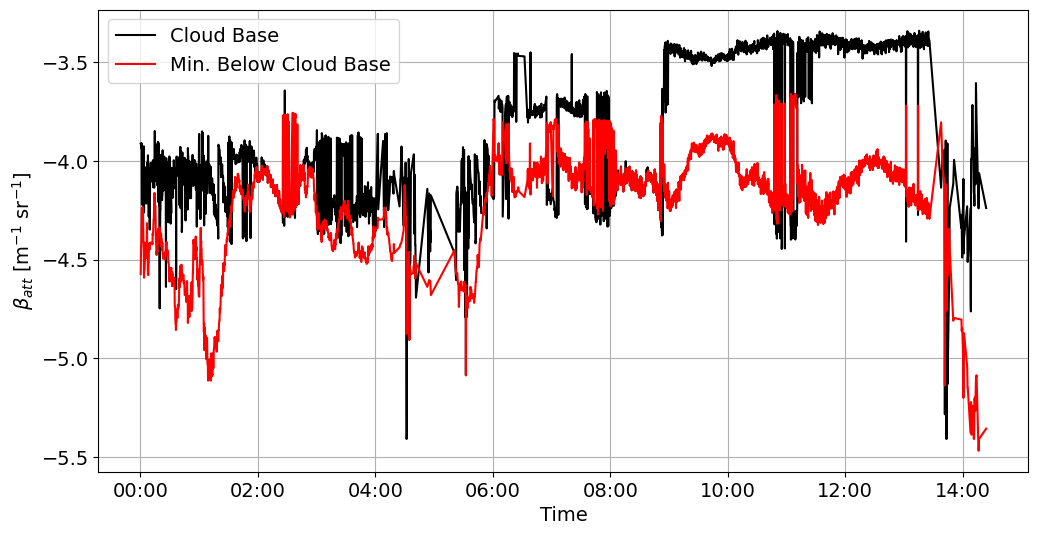

In [136]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
Fontsize=14
dfmt = mdates.DateFormatter('%H:%M')
ax1.tick_params(labelsize=Fontsize)
ax1.set_xlabel('Time',fontsize=Fontsize)
ax1.set_ylabel('$\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)
ax1.grid()
ax1.plot(dum_time_dt,dum_fog_cloud_base_beta_att,c='k',label='Cloud Base')
ax1.plot(dum_time_dt,dum_fog_min_beta_att,c='r',label='Min. Below Cloud Base')
ax1.xaxis.set_major_formatter(dfmt)
ax1.legend(fontsize=Fontsize)

plt.show()

In [131]:
dumid = np.where((dumout['arm_cbh'] < 250.) & (dumout['arm_cbh'] > 0.))[0]
dum_arm_fog_mask = dumout['arm_fog_mask'][dumid]
dum_arm_fog_cloud_base_beta_att = dumout['arm_fog_cloud_base_beta_att'][dumid]
dum_arm_fog_min_beta_att = dumout['arm_fog_min_beta_att'][dumid]
dum_arm_time_dt = dumout['time_dt'][dumid]

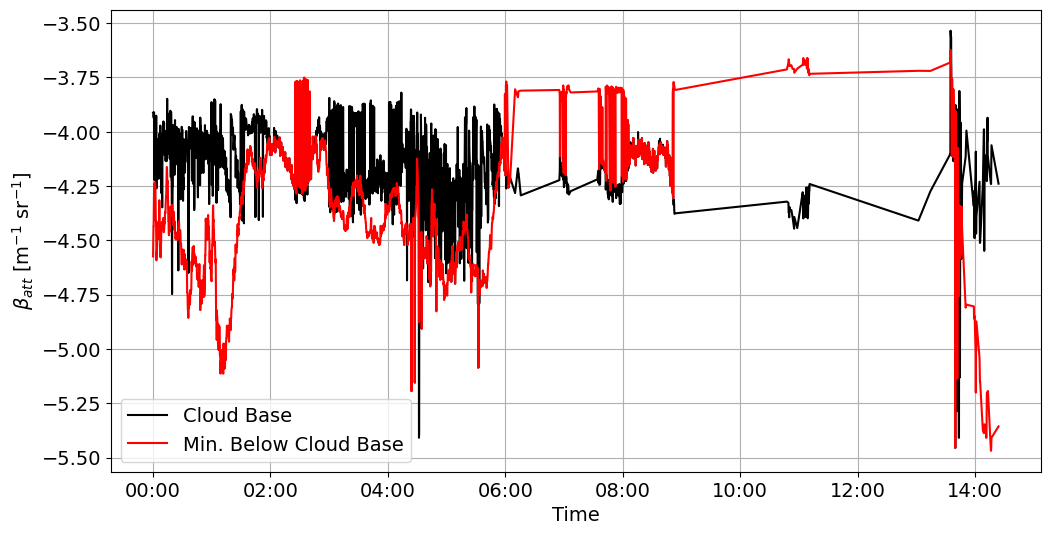

In [132]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
Fontsize=14
ax1.tick_params(labelsize=Fontsize)
ax1.set_xlabel('Time',fontsize=Fontsize)
ax1.set_ylabel('$\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)
ax1.grid()
ax1.plot(dum_arm_time_dt,dum_arm_fog_cloud_base_beta_att,c='k',label='Cloud Base')
ax1.plot(dum_arm_time_dt,dum_arm_fog_min_beta_att,c='r',label='Min. Below Cloud Base')
ax1.xaxis.set_major_formatter(dfmt)
ax1.legend(fontsize=Fontsize)

plt.show()

In [133]:
dumid = np.where((dumout['aad_cbh'] < 250.) & (dumout['aad_cbh'] > 0.))[0]
dum_aad_fog_mask = dumout['aad_fog_mask'][dumid]
dum_aad_fog_cloud_base_beta_att = dumout['aad_fog_cloud_base_beta_att'][dumid]
dum_aad_fog_min_beta_att = dumout['aad_fog_min_beta_att'][dumid]
dum_aad_time_dt = dumout['time_dt'][dumid]

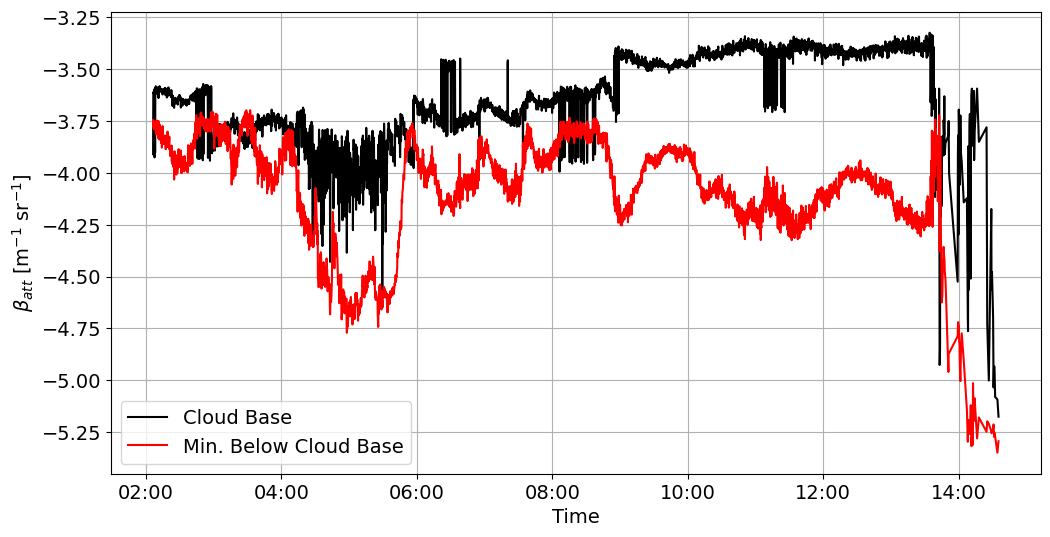

In [134]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
Fontsize=14
ax1.tick_params(labelsize=Fontsize)
ax1.set_xlabel('Time',fontsize=Fontsize)
ax1.set_ylabel('$\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)
ax1.grid()
ax1.plot(dum_aad_time_dt,dum_aad_fog_cloud_base_beta_att,c='k',label='Cloud Base')
ax1.plot(dum_aad_time_dt,dum_aad_fog_min_beta_att,c='r',label='Min. Below Cloud Base')
ax1.xaxis.set_major_formatter(dfmt)
ax1.legend(fontsize=Fontsize)

plt.show()

In [ ]:
#if False:
if True:
    fig = plt.figure(figsize=(22,18))
    ax1 = fig.add_subplot(521)
    ax2 = fig.add_subplot(522)
    ax3 = fig.add_subplot(523)
    ax4 = fig.add_subplot(524)
    ax5 = fig.add_subplot(525)
    ax6 = fig.add_subplot(526)
    ax7 = fig.add_subplot(527)
    ax8 = fig.add_subplot(528)
    ax9 = fig.add_subplot(529)
    ax10 = fig.add_subplot(5,2,10)
    dfmt = mdates.DateFormatter('%H:%M')
    Fontsize=14
    axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
    for ax in axlist:
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.grid(True)
        ax.xaxis.set_major_formatter(dfmt)
        ax.set_axisbelow(False)
        
    ax1.scatter(dumout['time_dt'],dumout['ctt'],s=2,c='red')
    ax1.set_ylabel('ctt [$^{\\circ}$C]',fontsize=Fontsize)
    ax1.set_ylim(-40,20)
    
    ax2.scatter(dumout['time_dt'],dumout['cbt'],s=2,c='red')
    ax2.set_ylabel('cbt [$^{\\circ}$C]',fontsize=Fontsize)
    ax2.set_ylim(-40,20)
    
    ax3.scatter(dumout['time_dt'],dumout['cbh'],s=2,c='blue')
    ax3.set_ylabel('cbh [m]',fontsize=Fontsize)
    ax3.set_ylim(0,6000)

    ax4.scatter(dumout['time_dt'],dumout['cth'],s=2,c='blue')
    ax4.set_ylabel('cth[m]',fontsize=Fontsize)
    ax4.set_ylim(0,6000)
    
    ax5.scatter(dumout['time_dt'],dumout['c_thick'],s=2,c='blue')
    ax5.set_ylabel('c_thick [m]',fontsize=Fontsize)
    ax5.set_ylim(0,6000)

    ax6.scatter(dumout['time_dt'],dumout['cloud_binary'],s=2,c='darkorange',label='cloud_binary')
    ax6.scatter(dumout['time_dt'],dumout['precip_binary'],s=1,c='blue',label='precip_binary')
    ax6.legend(loc='center right',fontsize=Fontsize)
    ax6.set_ylabel('Binaries',fontsize=Fontsize)
    ax6.set_ylim(-0.05,1.05)    
    
    cloud_id = np.where(dumout['cloud_binary'] == 1.)
    precip_id = np.where(dumout['precip_binary'] == 1.)
    dumstr = str(np.around((np.size(precip_id)/np.size(cloud_id))*100.,2))
    ax6.set_title('% Precip: {}'.format(dumstr),fontsize=Fontsize*1.5)
    
    ax7.scatter(dumout['time_dt'],dumout['ref_mean_bel'],s=2,c='blue')
    ax7.set_ylabel('ref_mean_bel [dBZ]',fontsize=Fontsize)
    ax7.set_ylim(-60,20)    
    
    ax8.scatter(dumout['time_dt'],dumout['vel_min_bel'],s=2,c='blue')
    ax8.set_ylabel('vel_min_bel [m s$^{-1}$]',fontsize=Fontsize)
    ax8.set_ylim(-10,2)  
    
    ax9.scatter(dumout['time_dt'],dumout['ref_grad_above'],s=2,c='blue')
    ax9.set_ylabel('ref_grad_above [dBZ m$^{-1}$]',fontsize=Fontsize)
    ax9.set_ylim(-0.5,0.5)      

    ax10.scatter(dumout['time_dt'],dumout['ref_grad_below'],s=2,c='blue')
    ax10.set_ylabel('ref_grad_below [dBZ m$^{-1}$]',fontsize=Fontsize)
    ax10.set_ylim(-0.5,0.5)    
    
    
    plt.subplots_adjust(hspace=0.6)
    plt.show()
    plt.close()
    

In [ ]:
#if False:
if True:
    fig = plt.figure(figsize=(22,18))
    ax1 = fig.add_subplot(521)
    ax2 = fig.add_subplot(522)
    ax3 = fig.add_subplot(523)
    ax4 = fig.add_subplot(524)
    ax5 = fig.add_subplot(525)
    ax6 = fig.add_subplot(526)
    ax7 = fig.add_subplot(527)
    ax8 = fig.add_subplot(528)
    ax9 = fig.add_subplot(529)
    ax10 = fig.add_subplot(5,2,10)
    dfmt = mdates.DateFormatter('%H:%M')
    Fontsize=14
    axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
    for ax in axlist:
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.grid(True)
        ax.xaxis.set_major_formatter(dfmt)
        ax.set_axisbelow(False)
        
    ax1.scatter(dumout['time_dt'],dumout['rcb'],s=2,c='blue')
    ax1.set_ylabel('rcb [mm hr$^{-1}$]',fontsize=Fontsize)
    ax1.set_yscale('log')
    ax1.set_ylim(1.e-5,1.e2)

    ax2.scatter(dumout['time_dt'],dumout['LWflx'],s=2,c='red',label='Liquid')
    ax2.scatter(dumout['time_dt'],dumout['IWflx'],s=2,c='blue',label='Ice')
    ax2.legend(loc='upper right',fontsize=Fontsize)
    ax2.set_ylabel('sfc_rcb [mm hr$^{-1}$]',fontsize=Fontsize)
    ax2.set_ylim(1.e-5,1.e2)
    ax2.set_yscale('log')    

    ax3.scatter(dumout['time_dt'],dumout['precip_updraft_binary'],s=2,c='blue')
    ax3.set_ylabel('precip_updraft_binary',fontsize=Fontsize)
    ax3.set_ylim(-0.05,1.05)     
    
    ax4.scatter(dumout['time_dt'],dumout['temperature_mean_bel'],s=2,c='red')
    ax4.set_ylabel('temperature_mean_bel [$^{\\circ}$C]',fontsize=Fontsize)
    ax4.set_ylim(-20,10)  
    
    ax5.scatter(dumout['time_dt'],dumout['virga_binary'],s=2,c='blue')
    ax5.set_ylabel('virga_binary',fontsize=Fontsize)
    ax5.set_ylim(-0.05,1.05)
    
    ax6.scatter(dumout['time_dt'],dumout['cloud_50m_thick_binary'],s=2,c='blue')
    ax6.set_ylabel('cloud_50m_thick_binary',fontsize=Fontsize)
    ax6.set_ylim(-0.05,1.05)    

    ax7.scatter(dumout['time_dt'],dumout['ref_at_cbh_binary'],s=2,c='blue')
    ax7.set_ylabel('ref_at_cbh_binary',fontsize=Fontsize)
    ax7.set_ylim(-0.05,1.05)        

    ax8.scatter(dumout['time_dt'],dumout['ref_above_cbh_binary'],s=2,c='blue')
    ax8.set_ylabel('ref_above_cbh_binary',fontsize=Fontsize)
    ax8.set_ylim(-0.05,1.05)    

    ax9.scatter(dumout['time_dt'],dumout['ref_below_cbh_binary'],s=2,c='blue')
    ax9.set_ylabel('ref_below_cbh_binary',fontsize=Fontsize)
    ax9.set_ylim(-0.05,1.05)  

    ax10.scatter(dumout['time_dt'],dumout['single_layer_binary'],s=2,c='blue')
    ax10.set_ylabel('single_layer_binary',fontsize=Fontsize)
    ax10.set_ylim(-0.05,1.05) 
    

    plt.subplots_adjust(hspace=0.6)
    plt.show()
    plt.close()
    

In [ ]:
#if False:
if True:
    fig = plt.figure(figsize=(22,18))
    ax1 = fig.add_subplot(521)
    ax2 = fig.add_subplot(522)
    ax3 = fig.add_subplot(523)
    ax4 = fig.add_subplot(524)
    ax5 = fig.add_subplot(525)
    ax6 = fig.add_subplot(526)
    ax7 = fig.add_subplot(527)
    ax8 = fig.add_subplot(528)
    ax9 = fig.add_subplot(529)
    ax10 = fig.add_subplot(5,2,10)
    dfmt = mdates.DateFormatter('%H:%M')
    Fontsize=14
    axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
    for ax in axlist:
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.grid(True)
        ax.xaxis.set_major_formatter(dfmt)
        ax.set_axisbelow(False)
        
 

    ax1.scatter(dumout['time_dt'],dumout['Z_min_mean_bel'],s=2,c='blue')
    ax1.set_ylabel('Z_min_mean_bel [dBZ]',fontsize=Fontsize)
    ax1.set_ylim(-60,-20)     

    ax2.scatter(dumout['time_dt'],dumout['virga_base_height'],s=2,c='blue')
    ax2.set_ylabel('virga_base_height [m]',fontsize=Fontsize)
    ax2.set_ylim(0,6000) 

    
    ax3.scatter(dumout['time_dt'],dumout['precip_to_sfc_binary'],s=2,c='blue')
    ax3.set_ylabel('precip_to_sfc_binary',fontsize=Fontsize)
    ax3.set_ylim(-0.05,1.05) 

    
    ax4.scatter(dumout['time_dt'],dumout['cbh_bel_min_binary'],s=2,c='blue')
    ax4.set_ylabel('cbh_bel_min_binary',fontsize=Fontsize)
    ax4.set_ylim(-0.05,1.05) 

    
    ax5.scatter(dumout['time_dt'],dumout['ref_within_100m_above_cbh_binary'],s=2,c='blue')
    ax5.set_ylabel('ref_within_100m_above_cbh_binary',fontsize=Fontsize)
    ax5.set_ylim(-0.05,1.05) 
    
    ax6.scatter(dumout['time_dt'],dumout['ref_within_100m_below_cbh_binary'],s=2,c='blue')
    ax6.set_ylabel('ref_within_100m_below_cbh_binary',fontsize=Fontsize)
    ax6.set_ylim(-0.05,1.05)     

    
    ax7.scatter(dumout['time_dt'],dumout['ref_through_100m_above_binary'],s=2,c='blue')
    ax7.set_ylabel('ref_through_100m_above_binary',fontsize=Fontsize)
    ax7.set_ylim(-0.05,1.05)     
    
    ax8.scatter(dumout['time_dt'],dumout['ref_through_100m_below_binary'],s=2,c='blue')
    ax8.set_ylabel('ref_through_100m_below_binary',fontsize=Fontsize)
    ax8.set_ylim(-0.05,1.05) 
    
    ax9.scatter(dumout['time_dt'],dumout['num_ref_cloud_layers_in_profile'],s=2,c='blue')
    ax9.set_ylabel('num_ref_cloud_layers_in_profile',fontsize=Fontsize)
    ax9.set_ylim(0,12)
    
    ax10.scatter(dumout['time_dt'],dumout['num_ceil_cbh_in_profile'],s=2,c='blue')
    ax10.set_ylabel('num_ceil_cbh_in_profile',fontsize=Fontsize)
    ax10.set_ylim(0,4)
    
    plt.subplots_adjust(hspace=0.6)
    plt.show()
    plt.close()
    

In [ ]:
#if False:
if True:
    fig = plt.figure(figsize=(22,18))
    ax1 = fig.add_subplot(521)
    ax2 = fig.add_subplot(522)
    ax3 = fig.add_subplot(523)
    ax4 = fig.add_subplot(524)
    ax5 = fig.add_subplot(525)
    ax6 = fig.add_subplot(526)
    ax7 = fig.add_subplot(527)
    ax8 = fig.add_subplot(528)
    ax9 = fig.add_subplot(529)
    ax10 = fig.add_subplot(5,2,10)
    dfmt = mdates.DateFormatter('%H:%M')
    Fontsize=14
    axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
    for ax in axlist:
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.grid(True)
        ax.xaxis.set_major_formatter(dfmt)
        ax.set_axisbelow(False)
        
 

    ax1.scatter(dumout['time_dt'],dumout['nearest_ref_above_cbh'],s=2,c='blue')
    ax1.set_ylabel('nearest_ref_above_cbh',fontsize=Fontsize)
    ax1.set_ylim(0,5000)     
    
    ax2.scatter(dumout['time_dt'],dumout['nearest_ref_below_cbh'],s=2,c='blue')
    ax2.set_ylabel('nearest_ref_below_cbh',fontsize=Fontsize)
    ax2.set_ylim(0,5000)
    
    ax3.scatter(dumout['time_dt'],dumout['cluster_id'],s=2,c='blue')
    ax3.set_ylabel('cluster_id',fontsize=Fontsize)
    ax3.set_ylim(0,6) 
    
    ax4.scatter(dumout['time_dt'],dumout['sfc_met_temperature'],s=2,c='red')
    ax4.set_ylabel('sfc_met_temperature',fontsize=Fontsize)
    ax4.set_ylim(-10,10) 
    
    ax5.scatter(dumout['time_dt'],dumout['sfc_met_rh'],s=2,c='blue')
    ax5.set_ylabel('sfc_met_rh',fontsize=Fontsize)
    ax5.set_ylim(0,100) 
    
    ax6.scatter(dumout['time_dt'],dumout['sfc_met_pressure'],s=2,c='blue')
    ax6.set_ylabel('sfc_met_pressure',fontsize=Fontsize)
    ax6.set_ylim(90,100) 
    
    ax7.scatter(dumout['time_dt'],dumout['sfc_met_wind_speed'],s=2,c='blue')
    ax7.set_ylabel('sfc_met_wind_speed',fontsize=Fontsize)
    ax7.set_ylim(0,50)     

    ax8.scatter(dumout['time_dt'],dumout['sfc_met_wind_dir'],s=2,c='blue')
    ax8.set_ylabel('sfc_met_wind_dir',fontsize=Fontsize)
    ax8.set_ylim(0,360)     
    
    plt.subplots_adjust(hspace=0.6)
    plt.show()
    plt.close()
    

In [ ]:
if True:
    fig = plt.figure(figsize=(22,18))
    ax1 = fig.add_subplot(521)
    ax2 = fig.add_subplot(522)
    ax3 = fig.add_subplot(523)
    ax4 = fig.add_subplot(524)
    ax5 = fig.add_subplot(525)
    ax6 = fig.add_subplot(526)
    ax7 = fig.add_subplot(527)
    ax8 = fig.add_subplot(528)
    ax9 = fig.add_subplot(529)
    ax10 = fig.add_subplot(5,2,10)
    dfmt = mdates.DateFormatter('%H:%M')
    Fontsize=14
    axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
    for ax in axlist:
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.grid(True)
        ax.xaxis.set_major_formatter(dfmt)
        ax.set_axisbelow(False)
        
    ax1.scatter(dumout['time_dt'],dumout['sfc_rh_mean'],s=2,c='blue')
    ax1.set_ylabel('sfc_rh_mean [%]',fontsize=Fontsize)
    
    ax2.scatter(dumout['time_dt'],dumout['sfc_temperature_mean'],s=2,c='red')
    ax2.set_ylabel('sfc_temperature_mean [$^{\\circ}$C]',fontsize=Fontsize)
    
    ax3.scatter(dumout['time_dt'],dumout['sfc_ref_mean'],s=2,c='blue')
    ax3.set_ylabel('sfc_ref_mean [dBZ]',fontsize=Fontsize)
    ax3.set_ylim(-60,20)

    ax4.scatter(dumout['time_dt'],dumout['sfc_vel_min'],s=2,c='blue')
    ax4.set_ylabel('sfc_vel_min [m s$^{-1}$]',fontsize=Fontsize)
    ax4.set_ylim(-10,5)
    
    ax5.scatter(dumout['time_dt'],dumout['sfc_rcb'],s=2,c='blue')
    ax5.set_ylabel('sfc_rcb [mm hr$^{-1}$]',fontsize=Fontsize)
    ax5.set_ylim(1.e-5,1.e2)
    ax5.set_yscale('log')

    ax6.scatter(dumout['time_dt'],dumout['sfc_cloud_binary'],s=2,c='darkorange',label='cloud_binary')
    ax6.scatter(dumout['time_dt'],dumout['sfc_precip_binary'],s=1,c='blue',label='precip_binary')
    ax6.legend(loc='lower right',fontsize=Fontsize)
    ax6.set_ylabel('Binaries',fontsize=Fontsize)
    ax6.set_ylim(-0.05,1.05)
    
    cloud_id = np.where(dumout['sfc_cloud_binary'] == 1.)
    precip_id = np.where(dumout['sfc_precip_binary'] == 1.)
    dumstr = str(np.around((np.size(precip_id)/np.size(cloud_id))*100.,2))
    ax6.set_title('% Precip: {}'.format(dumstr),fontsize=Fontsize*1.5)

    ax7.scatter(dumout['time_dt'],dumout['sfc_LWflx'],s=2,c='red',label='Liquid')
    ax7.scatter(dumout['time_dt'],dumout['sfc_IWflx'],s=2,c='blue',label='Ice')
    ax7.legend(loc='upper right',fontsize=Fontsize)
    ax7.set_ylabel('sfc_rcb [mm hr$^{-1}$]',fontsize=Fontsize)
    ax7.set_ylim(1.e-5,1.e2)
    ax7.set_yscale('log')
    
    ax8.scatter(dumout['time_dt'],dumout['sfc_ref_through_100m_binary'],s=2,c='blue')
    ax8.set_ylabel('sfc_ref_through_100m_binary',fontsize=Fontsize*0.75)
    ax8.set_ylim(0,1.05)
    
    ax9.scatter(dumout['time_dt'],dumout['sfc_precip_updraft_binary'],s=2,c='blue')
    ax9.set_ylabel('sfc_precip_updraft_binary',fontsize=Fontsize*0.75)
    ax9.set_ylim(0,1.05)    
    
    ax10.scatter(dumout['time_dt'],dumout['sfc_ref_grad'],s=2,c='blue')
    ax10.set_ylabel('sfc_ref_grad [dBZ m$^{-1}$]',fontsize=Fontsize*0.75)
    ax10.set_ylim(-0.4,0.4)
    
    plt.subplots_adjust(hspace=0.6)
    plt.show()
    plt.close()
    